In [1]:
# optional but useful for debugging - reimports modules after editing and saving .py files
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import astropy
from astropy import units as u
#import astromet
import dev.astromet.astromet as astromet
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm
import scanninglaw.times
from scanninglaw.source import Source
import h5py
import seaborn as sns

In [133]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=1
mpl.rcParams['font.family'] = 'Avenir'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=10
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5

In [4]:
# slooow step - see scanning_law package for details
dr3_sl=scanninglaw.times.dr2_sl(version='dr3_nominal')

Loading auxilliary data ...
t = 32.617 s
  auxilliary:  16.775 s
          sf:   5.049 s
interpolator:  10.793 s


In [5]:
dr3Period=34/12 # in years
mas=astromet.mas # conversion from degrees to milli-arcseconds

In [6]:
gums_file='data/gums_sample_reparameterised.h'

with h5py.File(gums_file, 'r') as f:
    gums = {}
    for key in f.keys():
        gums[key] = f[key][...]
print(gums.keys())

fits_file='data/gums_fits_singlesandunresolved_parallel.h'

with h5py.File(fits_file, 'r') as f:
    fits = {k:v[:] for k,v in f.items()}
print(fits.keys())

delta_file='data/gums_fits_unresolved_dr2&3.h'

with h5py.File(delta_file, 'r') as f:
    delta = {k:v[:] for k,v in f.items()}
print(delta.keys())

dict_keys(['a', 'age', 'alphafe', 'barycentric_distance', 'binary', 'dec', 'e', 'feh', 'flipped', 'inclination', 'l', 'longitude_ascending_node', 'parallax', 'periastron_argument', 'periastron_date', 'period', 'phot_g_mean_mag', 'pmdec', 'pmra', 'population', 'primary_logg', 'primary_mag_bp', 'primary_mag_g', 'primary_mag_rp', 'primary_mag_rvs', 'primary_mass', 'primary_radius', 'primary_teff', 'primary_variability_amplitude', 'primary_variability_period', 'primary_variability_phase', 'primary_variability_type', 'primary_vsini', 'q', 'ra', 'radial_velocity', 'secondary_logg', 'secondary_mag_bp', 'secondary_mag_g', 'secondary_mag_rp', 'secondary_mag_rvs', 'secondary_mass', 'secondary_radius', 'secondary_teff', 'secondary_variability_amplitude', 'secondary_variability_period', 'secondary_variability_phase', 'secondary_variability_type', 'secondary_vsini', 'system_id', 'tperi', 'unresolved', 'vomega', 'vphi', 'vtheta'])
dict_keys(['UWE', 'astrometric_chi2_al', 'astrometric_excess_noise', 

In [7]:
# single star data
singles=np.flatnonzero(gums['binary']==False)

sras=gums['ra'][singles]
sdecs=gums['dec'][singles]
spmras=gums['pmra'][singles]
spmdecs=gums['pmdec'][singles]
spllxs=1000/gums['barycentric_distance'][singles]
smags=gums['primary_mag_g'][singles]

In [165]:
# binary star data
binaries=np.flatnonzero(gums['binary']==True)

pllxs=1000/gums['barycentric_distance'] # mas
semis=gums['a'] # au
eccs=gums['e']
# randomly generating viewing angles because I got too confused by the argument of pericentre
vthetas=gums['vtheta']#np.arccos(-1+2*np.random.rand(pllxs.size)) # rad
vphis=gums['vphi']#2*np.pi*np.random.rand(pllxs.size) # rad
vomegas=gums['vomega']#2*np.pi*np.random.rand(pllxs.size) # rad

periods=gums['period']#gums['orbit_period']/astromet.T # years

tperis=gums['tperi']#2016+gums['periastron_date']/astromet.T
tot_mags=gums['phot_g_mean_mag']#-2.5*np.log10(10**(-0.4*gums['primary_mag_g'])+10**(-0.4*gums['secondary_mag_g']))
ptot_mags=gums['primary_mag_g']
stot_mags=gums['secondary_mag_g']
atot_mags=tot_mags - 10 + 5*np.log10(pllxs)
aptot_mags=ptot_mags - 10 + 5*np.log10(pllxs)
astot_mags=stot_mags - 10 + 5*np.log10(pllxs)
bps=-2.5*np.log10(10**(-0.4*gums['primary_mag_bp'])+10**(-0.4*gums['secondary_mag_bp']))
rps=-2.5*np.log10(10**(-0.4*gums['primary_mag_rp'])+10**(-0.4*gums['secondary_mag_rp']))
pcols=gums['primary_mag_bp']-gums['primary_mag_rp']
scols=gums['secondary_mag_bp']-gums['secondary_mag_rp']
cols=bps-rps
ls=gums['l']#10**(0.4*(gums['primary_mag_g']-gums['secondary_mag_g']))
qs=gums['q']#gums['secondary_mass']/gums['primary_mass']

misordered=np.flatnonzero(ls>1)
ls[misordered]=1/ls[misordered]
qs[misordered]=1/qs[misordered]
deltas=np.abs(qs-ls)/((1+ls)*(1+qs))

max_proj_sep=semis*pllxs*(1+eccs)*np.cos(vthetas)

ubins=np.flatnonzero((gums['binary']==True) & (max_proj_sep<180) & (periods<100)) # unresolved binaries
ualtbins=np.flatnonzero((gums['binary']==True) & (max_proj_sep<180))
#rbins=np.flatnonzero((gums['binary']==True) & (max_proj_sep>180)) # (partially) resolved binaries
nall=gums['ra'].size
nsingle=singles.size
nbinary=ubins.size
nother=nall-nsingle-nbinary


print(nall,' sources in 100 pc')
print(nsingle,' single sources')
print(nbinary,' unresolved binaries w. period < 100 years')
print(nother,' other sources')
print('(',ualtbins.size,' all unresolved binaries)')


uids=gums['system_id'][ubins]

uras=gums['ra'][ubins]
udecs=gums['dec'][ubins]
upmras=gums['pmra'][ubins]
upmdecs=gums['pmdec'][ubins]
upllxs=pllxs[ubins]

uperiods=periods[ubins]
uas=semis[ubins]
ues=eccs[ubins]

uls=ls[ubins]
uqs=qs[ubins]
udeltas=deltas[ubins]
utperis=tperis[ubins]

uvthetas=vthetas[ubins]
uvphis=vphis[ubins]
uvomegas=vomegas[ubins]

umags=tot_mags[ubins]
uamags=atot_mags[ubins]
ucols=cols[ubins]

puamags=aptot_mags[ubins]
pucols=pcols[ubins]

suamags=astot_mags[ubins]
sucols=scols[ubins]

126314  sources in 100 pc
93606  single sources
14431  unresolved binaries w. period < 100 years
18277  other sources
( 24809  all unresolved binaries)


In [9]:
# fit data
fids=fits['system_id']

fuwes=fits['UWE']
fras=fits['ra']
fraerrs=fits['ra_error']
fdecs=fits['dec']
fdecerrs=fits['dec_error']
fpllxs=fits['parallax']
fpllxerrs=fits['parallax_error']
fpmras=fits['pmra']
fpmraerrs=fits['pmra_error']
fpmdecs=fits['pmdec']
fpmdecerrs=fits['pmdec_error']

# inidices to pick out single stars
_,fsingles,_ = np.intersect1d(fits['system_id'], gums['system_id'][singles], return_indices=True)
_,fbinaries,_ = np.intersect1d(fits['system_id'], gums['system_id'][ubins], return_indices=True)

In [151]:
# classifying sources by their position on the HR diagram 
# as a combined source, and as primary and secondary

wdsel=np.flatnonzero((ucols<2) & (uamags > 4 + 5*ucols) & (uamags > 4))
dwarfsel=np.flatnonzero((ucols>2) & (uamags > 14))
giantsel=np.flatnonzero((uamags < 4) & (ucols>1))
ymssel=np.flatnonzero((uamags < 4) & (ucols<1))
mssel=np.flatnonzero((uamags > 4) & (uamags < 14)
           & (uamags < 4 + 5*ucols))
#source classification - 0=MS, 1=YMS, 2=Giant, 3=Dwarf, 4=WD
combclass=np.zeros(ucols.size)
combclass[ymssel]=1
combclass[giantsel]=2
combclass[dwarfsel]=3
combclass[wdsel]=4
combclass=combclass.astype(int)

wdprim=np.flatnonzero((pucols<2) & (puamags > 4 + 5*pucols) & (puamags > 4))
dwarfprim=np.flatnonzero((pucols>2) & (puamags > 14))
giantprim=np.flatnonzero((puamags < 4) & (pucols>1))
ymsprim=np.flatnonzero((puamags < 4) & (pucols<1))
msprim=np.flatnonzero((puamags > 4) & (puamags < 14)
           & (puamags < 4 + 5*pucols))

primclass=np.zeros(ucols.size).astype(int)
primclass[ymsprim]=1
primclass[giantprim]=2
primclass[dwarfprim]=3
primclass[wdprim]=4
primclass=primclass.astype(int)

wdsec=np.flatnonzero((sucols<2) & (suamags > 4 + 5*sucols) & (suamags > 4))
dwarfsec=np.flatnonzero((sucols>2) & (suamags > 14))
giantsec=np.flatnonzero((suamags < 4) & (sucols>1))
ymssec=np.flatnonzero((suamags < 4) & (sucols<1))
mssec=np.flatnonzero((suamags > 4) & (suamags < 14)
           & (suamags < 4 + 5*sucols))

secclass=np.zeros(ucols.size).astype(int)
secclass[ymssec]=1
secclass[giantsec]=2
secclass[dwarfsec]=3
secclass[wdsec]=4
secclass=secclass.astype(int)

classcols=np.array(['#fb8500','#219ebc','#d62828','#6a040f','#8ecae6'])
classnames=['MS','YMS','Giants','Dwarfs','WDs']

/Users/zephyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/zephyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


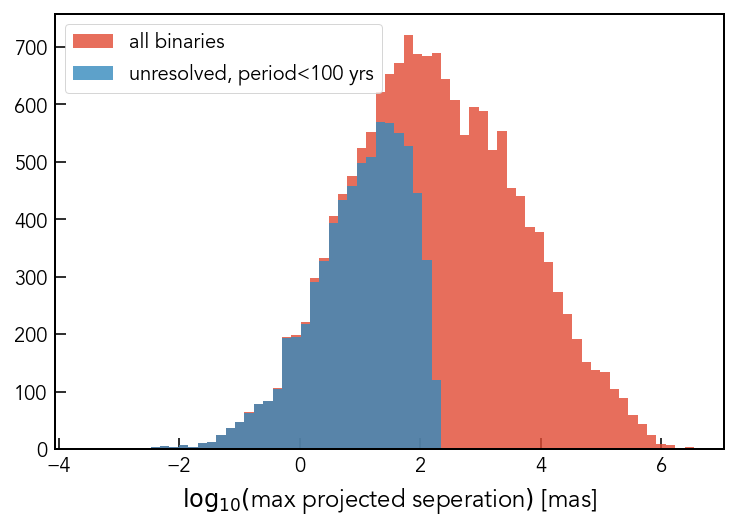

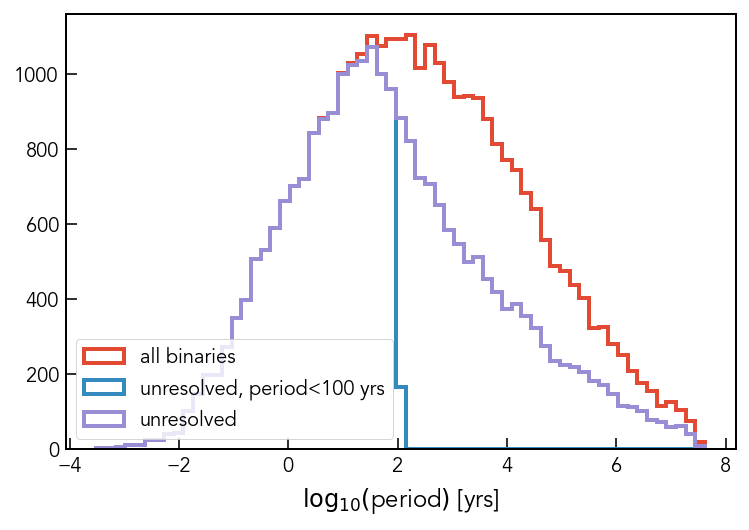

14431  unresolved binaries with period < 100 years 
 out of  126314  sources containing  32708  binaries.


In [152]:
#rbins=np.flatnonzero((gums['binary']==True) & (max_proj_sep>180) & (periods<30))
ax=plt.gca()
_,bins,_=ax.hist(np.log10(max_proj_sep[binaries]),bins='auto',label='all binaries',alpha=0.8)
ax.hist(np.log10(max_proj_sep[ubins]),bins=bins,label='unresolved, period<100 yrs',alpha=0.8)
#ax.hist(np.log10(max_proj_sep[rbins]),bins=bins,label='resolved, period<30 yrs',alpha=0.8)
#ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10}($max projected seperation$)$ [mas]')
plt.legend()
plt.show()

ax=plt.gca()
_,bins,_=ax.hist(np.log10(periods[binaries]),bins='auto',label='all binaries',histtype='step',lw=2)
ax.hist(np.log10(periods[ubins]),bins=bins,label='unresolved, period<100 yrs',histtype='step',lw=2)
ax.hist(np.log10(periods[ualtbins]),bins=bins,label='unresolved',histtype='step',lw=2)
#ax.hist(np.log10(max_proj_sep[rbins]),bins=bins,label='resolved, period<30 yrs',alpha=0.8)
#ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10}($period$)$ [yrs]')
plt.legend(loc=3)
plt.show()
print(ubins.size,' unresolved binaries with period < 100 years \n out of ',
      pllxs.size,' sources containing ',binaries.size,' binaries.')

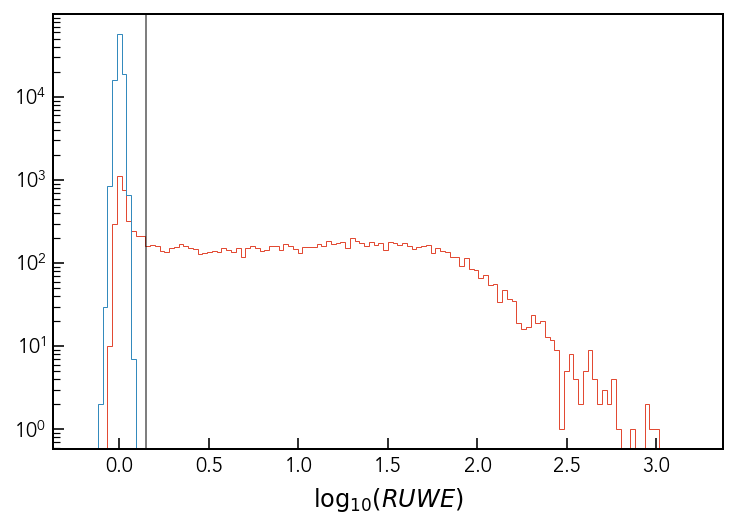

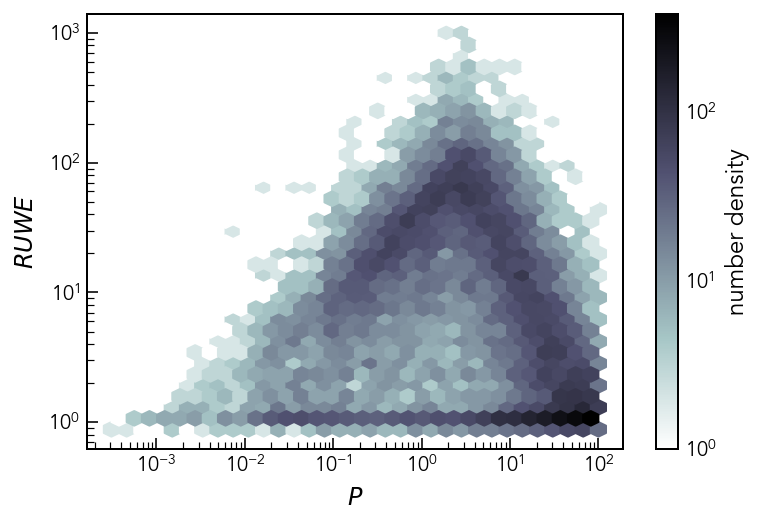

In [153]:
ax=plt.gca()
_,bins,_=ax.hist(np.log10(fuwes[fbinaries]),range=(-0.2,3.2),bins=128,histtype='step')
ax.hist(np.log10(fuwes[fsingles]),bins=bins,histtype='step')
ax.axvline(np.log10(1.4),c='k',lw=1,alpha=0.5)
ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10}(RUWE)$')
plt.show()

ax=plt.gca()
im=ax.hexbin(uperiods,fuwes[fbinaries],xscale='log',yscale='log',
             cmap='bone_r',bins='log',gridsize=32)
plt.colorbar(im,label='number density')
ax.set_ylabel(r'$RUWE$')
ax.set_xlabel(r'$P$')
plt.show()


In [160]:
def hrextras(ax,xvals=None,yvals=None,
        addcuts=True,addlabels=True,xlim=(-1,5.5),ylim=(20,-3),
            alpha=1,contourcol='k'):
    if ((np.size(xvals)>1) & (np.size(yvals)>1)):
        sns.kdeplot(x=xvals,y=yvals,ax=ax,linewidths=0.5,
                    zorder=2,alpha=alpha,color=contourcol,bw_adjust=0.4)
        # supressing seaborn's habit of adding unwanted labels, could cause bugs?
        ax.set_ylabel('')
        ax.set_xlabel('')
    vd=0.18
    hd=0.05
    if addcuts==True:
        ax.plot([2,2],[20,14],c='k',lw=1,alpha=alpha)
        ax.plot([0,2],[4,14],c='k',lw=1,alpha=alpha)
        #ax.plot([-1,1.5],[7.8,4],c='k',lw=1,alpha=alpha)
        #ax.plot([0+0.8*hd,2+0.8*hd],[4-0.4*vd,14-0.4*vd],c=classcols[0],lw=3,alpha=alpha)
        #ax.plot([0-0.8*hd,2-0.8*hd],[4+0.4*vd,14+0.4*vd],c=classcols[4],lw=3,alpha=alpha)
        #ax.plot([2,6],[14-vd,14-vd],c=classcols[0],lw=3,alpha=alpha)
        #ax.plot([2,6],[14+vd,14+vd],c=classcols[3],lw=3,alpha=alpha)
        #ax.plot([2-hd,2-hd],[14,20],c=classcols[4],lw=3,alpha=alpha)
        #ax.plot([2+hd,2+hd],[14+2*hd,20],c=classcols[3],lw=3,alpha=alpha)
        #ax.plot([1.8,3],[14.9,13.4],c='k',lw=1,alpha=alpha)
        ax.plot([2,6],[14,14],c='k',lw=1,alpha=alpha)
        ax.plot([6,-1],[4,4],c='k',lw=1,alpha=alpha)
        ax.plot([1,1],[4,-6],c='k',lw=1,alpha=alpha)
    if addlabels==True:
        ax.text(-0.7,-0.4,'YMS',fontsize=24,
                c=classcols[1],fontweight='bold')
        #ax.text(-0.6,7.2,'SMS',fontsize=16,c='grey')
        ax.text(3.5,-0.4,'Giants',fontsize=24,
                c=classcols[2],fontweight='bold')
        ax.text(-0.7,19,'WDs',fontsize=24,
                c=classcols[4],fontweight='bold')
        ax.text(3.5,19,'Dwarfs',fontsize=24,
                c=classcols[3],fontweight='bold')
        ax.text(4.3,7,'MS',fontsize=24,
                c=classcols[0],fontweight='bold')
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)

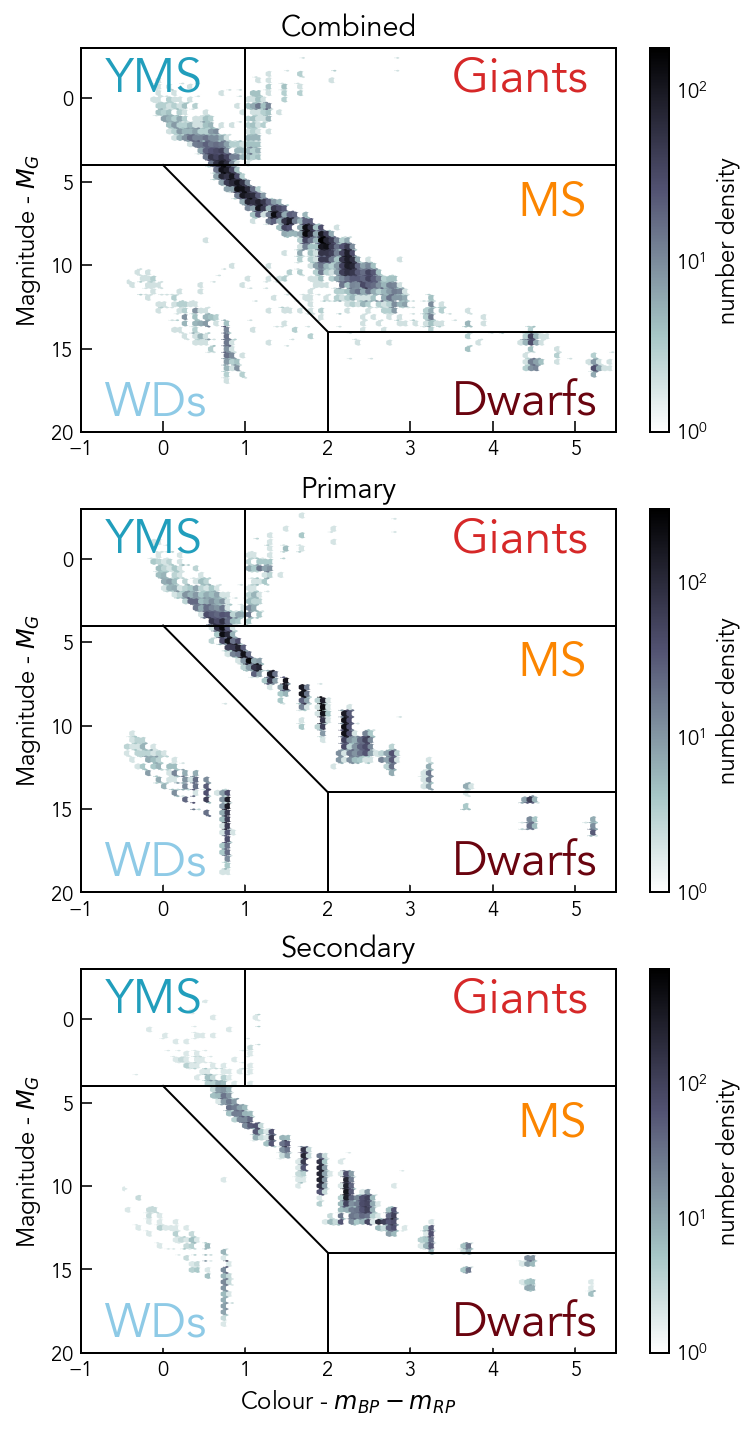

In [161]:
fig=plt.figure(figsize=(6,12))
grid=mpl.gridspec.GridSpec(3,1)

ucolscorr=ucols+0.0*np.random.randn(ubins.size)
pucolscorr=pucols+0.0*np.random.randn(pucols.size)
sucolscorr=sucols+0.0*np.random.randn(sucols.size)

ax=plt.subplot(grid[0,0])
hrextras(ax)
ax.set_title('Combined')
im=ax.hexbin(ucolscorr,uamags,cmap='bone_r',bins='log')
plt.colorbar(im,label='number density')
#ax.set_ylim(21,-3)
#ax.set_xlabel(r'$BP_{\Sigma}-RP_{\Sigma}$')
ax.set_ylabel(r'Magnitude - $M_{G}$')

ax=plt.subplot(grid[1,0])
hrextras(ax)
ax.set_title('Primary')
im=ax.hexbin(pucolscorr,puamags,cmap='bone_r',bins='log')
plt.colorbar(im,label='number density')
#ax.set_ylim(21,-3)
#ax.set_xlabel(r'$BP_{\Sigma}-RP_{\Sigma}$')
ax.set_ylabel(r'Magnitude - $M_{G}$')

ax=plt.subplot(grid[2,0])
hrextras(ax)
ax.set_title('Secondary')
im=ax.hexbin(sucolscorr,suamags,cmap='bone_r',bins='log')
plt.colorbar(im,label='number density')
#ax.set_ylim(21,-3)
ax.set_xlabel(r'Colour - $m_{BP}-m_{RP}$')
ax.set_ylabel(r'Magnitude - $M_{G}$')

plt.show()

/Users/zephyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  from ipykernel import kernelapp as app


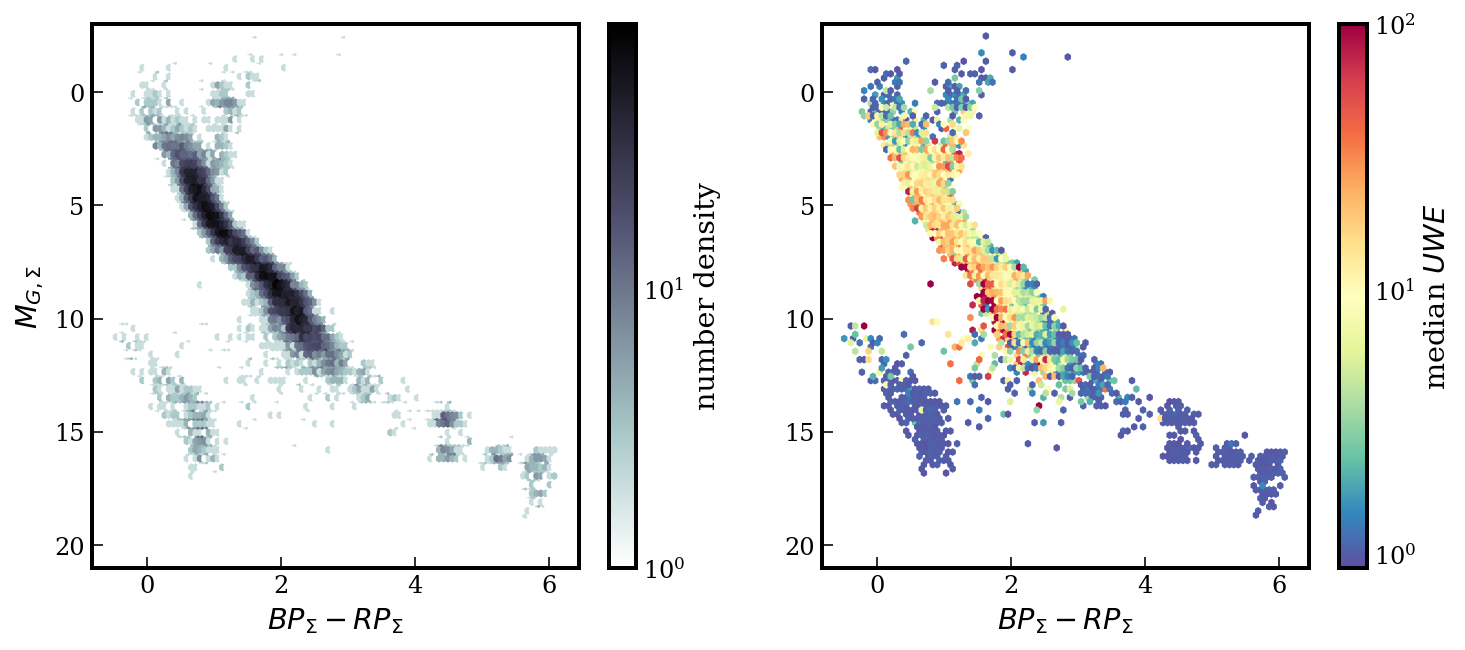

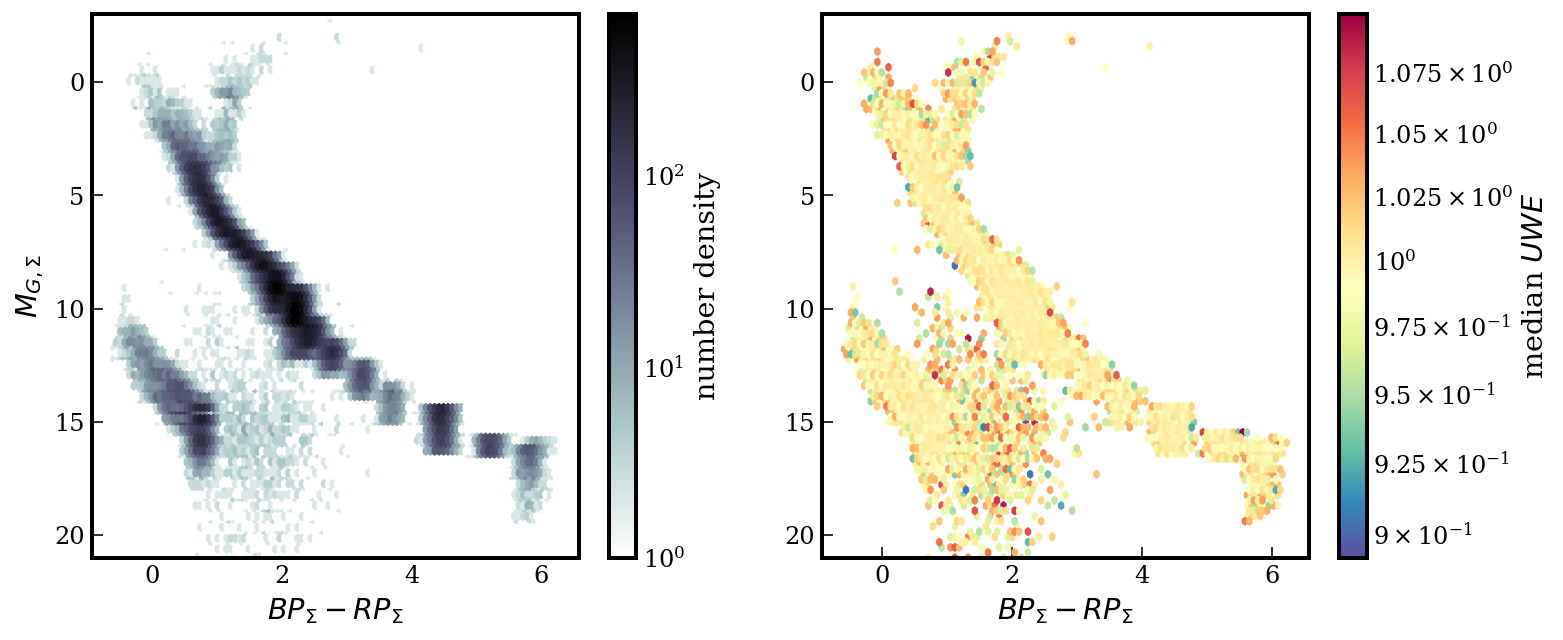

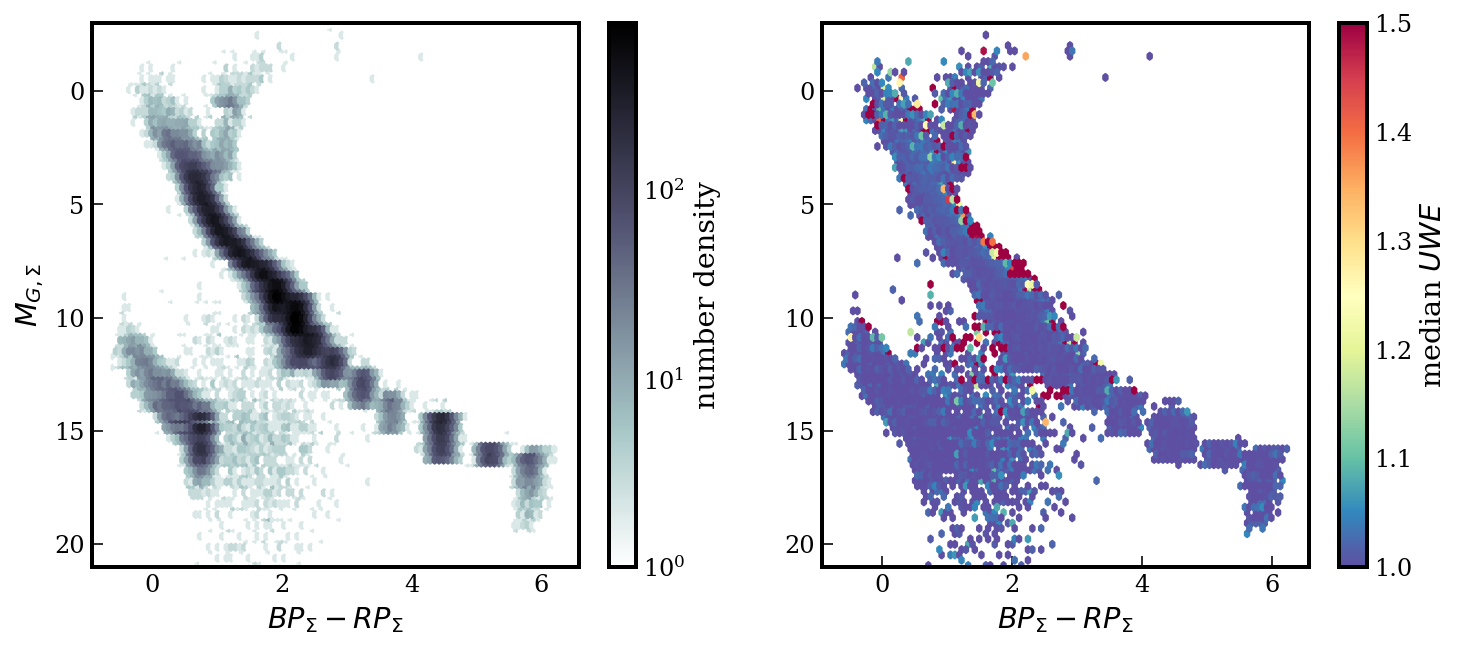

In [44]:
# single star colours quantized so adding some random noise
bcols=ucols+0.1*np.random.randn(ubins.size)

fig=plt.figure(figsize=(12,5))
grid=mpl.gridspec.GridSpec(1,2)
ax=plt.subplot(grid[0,0])
im=ax.hexbin(bcols,uamags,cmap='bone_r',bins='log')
plt.colorbar(im,label='number density')
ax.set_ylim(21,-3)
ax.set_xlabel(r'$BP_{\Sigma}-RP_{\Sigma}$')
ax.set_ylabel(r'$M_{G,\Sigma}$')

ax=plt.subplot(grid[0,1])
im=ax.hexbin(bcols,uamags,C=fuwes[fbinaries],reduce_C_function=np.median,
             cmap='Spectral_r',bins='log',vmax=100)
plt.colorbar(im,label='median $UWE$')
ax.set_ylim(21,-3)
ax.set_xlabel(r'$BP_{\Sigma}-RP_{\Sigma}$')
plt.show()

# single star colours quantized so adding some random noise
scols=pcols[singles]+0.1*np.random.randn(singles.size)

fig=plt.figure(figsize=(12,5))
grid=mpl.gridspec.GridSpec(1,2)
ax=plt.subplot(grid[0,0])
im=ax.hexbin(scols,atot_mags[singles],cmap='bone_r',bins='log')
plt.colorbar(im,label='number density')
ax.set_ylim(21,-3)
ax.set_xlabel(r'$BP_{\Sigma}-RP_{\Sigma}$')
ax.set_ylabel(r'$M_{G,\Sigma}$')

ax=plt.subplot(grid[0,1])
im=ax.hexbin(scols,atot_mags[singles],C=fuwes[fsingles],reduce_C_function=np.median,
             cmap='Spectral_r',bins='log')
plt.colorbar(im,label='median $UWE$')
ax.set_ylim(21,-3)
ax.set_xlabel(r'$BP_{\Sigma}-RP_{\Sigma}$')
plt.show()

allcols=np.hstack([bcols,scols])
allamags=np.hstack([uamags,atot_mags[singles]])
alluwes=np.hstack([fuwes[fbinaries],fuwes[fsingles]])

fig=plt.figure(figsize=(12,5))
grid=mpl.gridspec.GridSpec(1,2)
ax=plt.subplot(grid[0,0])
im=ax.hexbin(allcols,allamags,cmap='bone_r',bins='log')
plt.colorbar(im,label='number density')
ax.set_ylim(21,-3)
ax.set_xlabel(r'$BP_{\Sigma}-RP_{\Sigma}$')
ax.set_ylabel(r'$M_{G,\Sigma}$')

ax=plt.subplot(grid[0,1])
im=ax.hexbin(allcols,allamags,C=alluwes,reduce_C_function=np.median,
             cmap='Spectral_r',vmax=1.5,vmin=1)
plt.colorbar(im,label='median $UWE$')
ax.set_ylim(21,-3)
ax.set_xlabel(r'$BP_{\Sigma}-RP_{\Sigma}$')
plt.show()

In [39]:
print(rand)
print(classcols[primclass])

None
['#ffb703' '#ffb703' '#fb8500' ... '#219ebc' '#fb8500' '#d62828']


/Users/zephyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/Users/zephyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


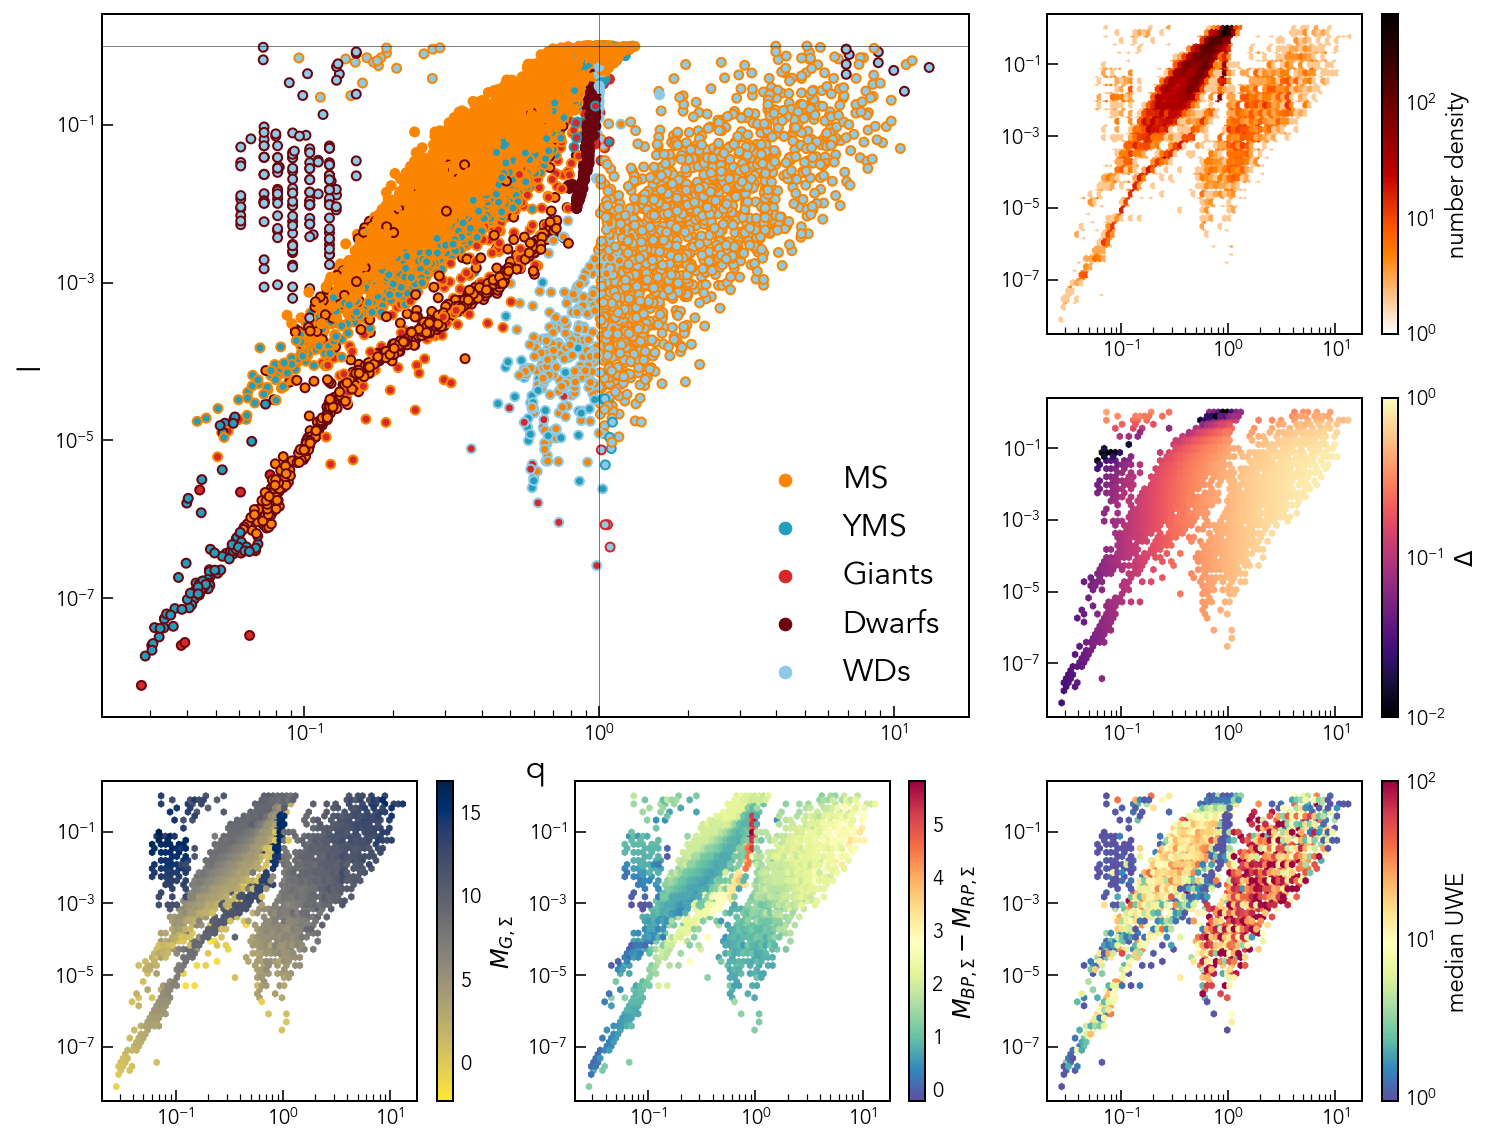

In [215]:
fig=plt.figure(figsize=(12,10))
grid=mpl.gridspec.GridSpec(3,3)

rand=np.arange(uqs.size)
np.random.shuffle(rand)

ax=plt.subplot(grid[0:2,0:2])
ax.scatter(uqs[rand],uls[rand],s=20,c=classcols[primclass][rand],
           edgecolor=classcols[secclass][rand],linewidths=1)
for i in range(5):
    ax.scatter([],[],c=classcols[i],label=classnames[i],s=40)
ax.set_xscale('log')
ax.set_yscale('log')
ax.axvline(1,c='k',lw=0.5,alpha=0.5)
ax.axhline(1,c='k',lw=0.5,alpha=0.5)
ax.set_xlabel('q',fontsize=16)
ax.set_ylabel('l',fontsize=16)
plt.legend(frameon=False,fontsize=16)


ax=plt.subplot(grid[0,2])
im=ax.hexbin(uqs,uls,
             xscale='log',yscale='log',cmap='gist_heat_r',bins='log',gridsize=64)
plt.colorbar(im,label='number density')


ax=plt.subplot(grid[1,2])
im=ax.hexbin(uqs,uls,C=deltas[ubins],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='magma',bins='log',
             gridsize=64,vmin=1e-2,vmax=1)
plt.colorbar(im,label=r'$\Delta$')

ax=plt.subplot(grid[2,0])
im=ax.hexbin(uqs,uls,C=uamags,reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='cividis_r',gridsize=64)
plt.colorbar(im,label=r'$M_{G,\Sigma}$')

ax=plt.subplot(grid[2,1])
im=ax.hexbin(uqs,uls,C=ucols,reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral_r',gridsize=64)
plt.colorbar(im,label=r'$M_{BP,\Sigma}-M_{RP,\Sigma}$')

ax=plt.subplot(grid[2,2])
im=ax.hexbin(uqs,uls,C=fuwes[fbinaries],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral_r',bins='log',gridsize=64,vmax=1e2)
plt.colorbar(im,label='median UWE')
plt.show()

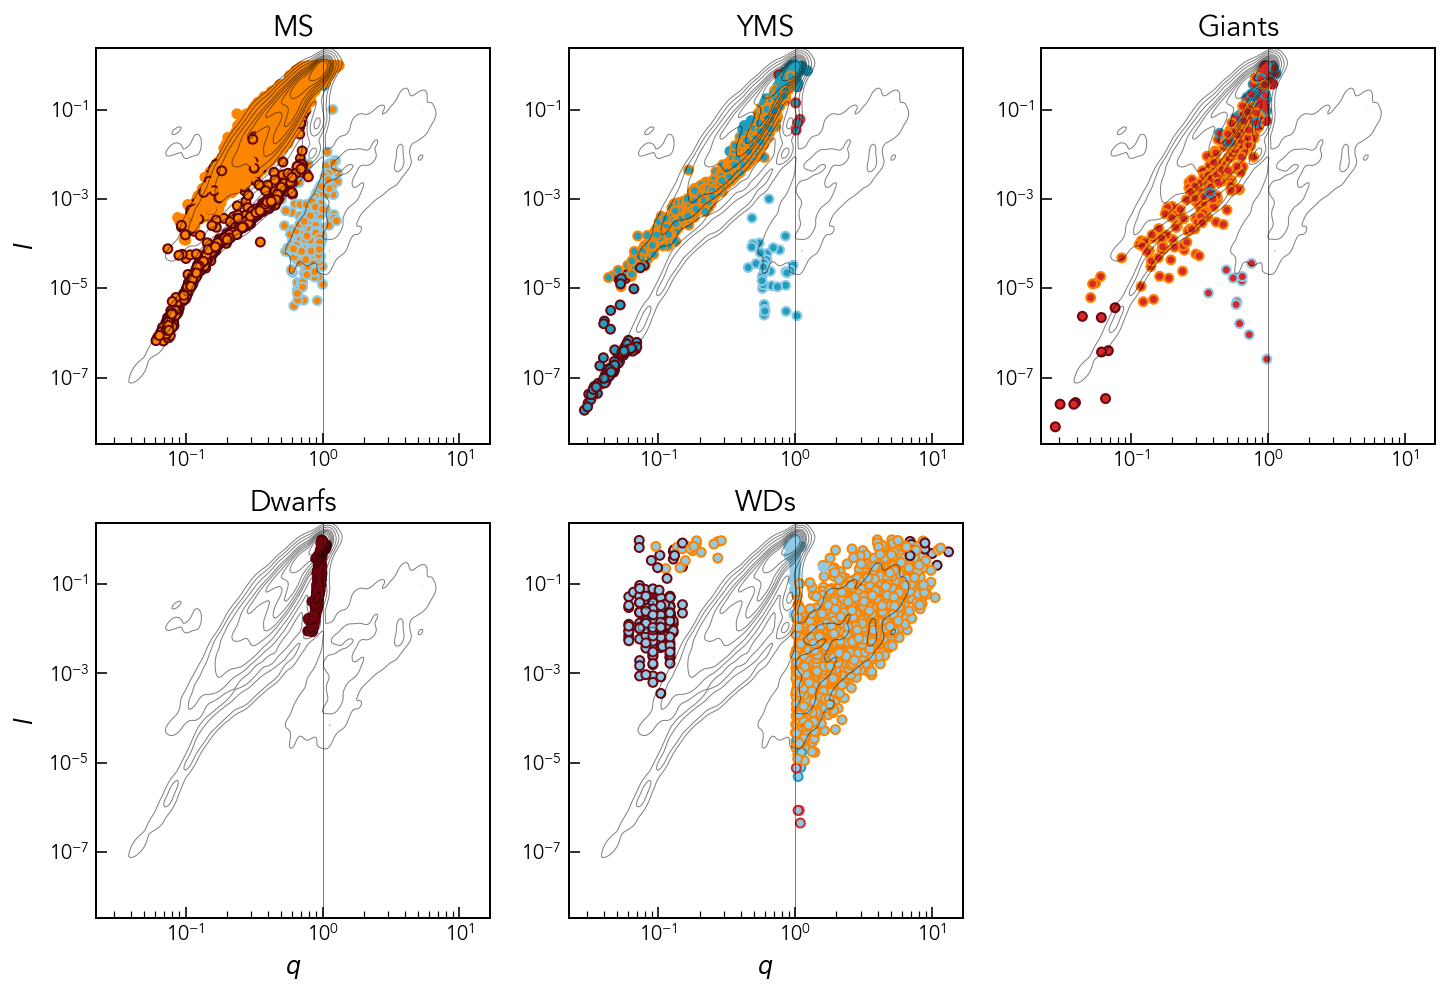

In [214]:
fig=plt.figure(figsize=(12,8))
grid=mpl.gridspec.GridSpec(2,3)

for i in range(5):
    
    rand=np.flatnonzero(primclass==i)
    np.random.shuffle(rand)

    ax=plt.subplot(grid[int(i/3),i%3])
    ax.set_title(classnames[i])
    sns.kdeplot(x=uqs,y=uls,ax=ax,linewidths=0.5,zorder=2,color='k',
            log_scale=True,bw_adjust=0.5,alpha=0.5)
    ax.scatter(uqs[rand],uls[rand],s=20,c=classcols[primclass][rand],
               edgecolor=classcols[secclass][rand],linewidths=1)
    ax.axvline(1,c='k',lw=0.5,alpha=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    #im=ax.hexbin(uqs,uls,C=fuwes[fbinaries],reduce_C_function=np.median,
    #             xscale='log',yscale='log',cmap='Spectral',bins='log',gridsize=64)
    #plt.colorbar(im,label='median UWE')
    if i>=3:
        ax.set_xlabel(r'$q$')
    if i%3==0:
        ax.set_ylabel(r'$l$')
plt.show()

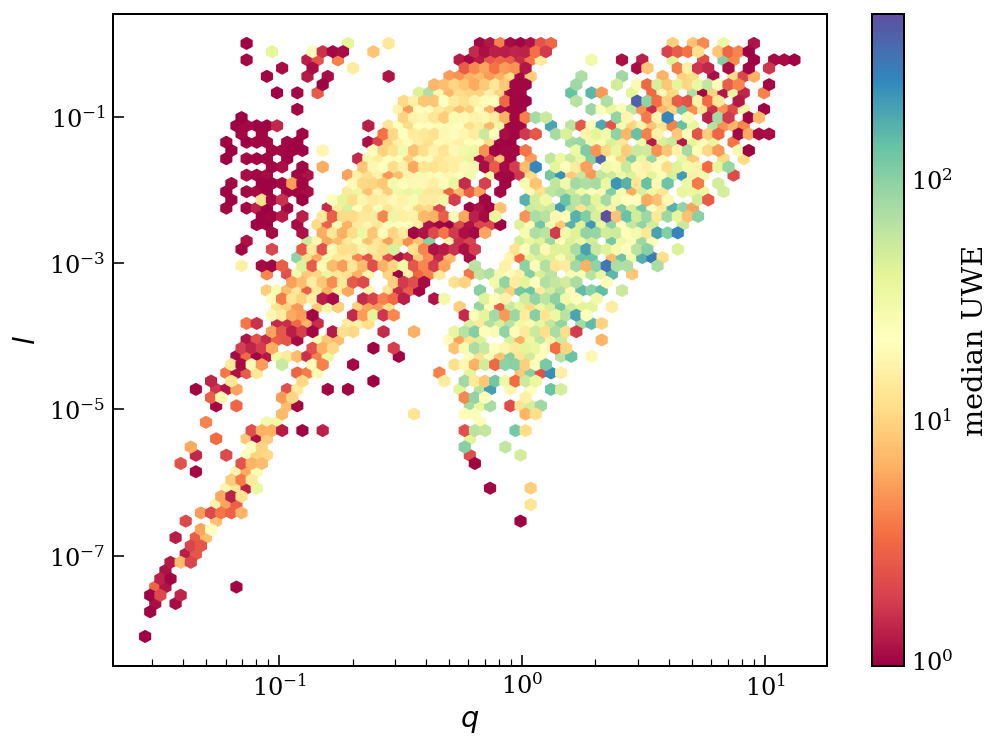

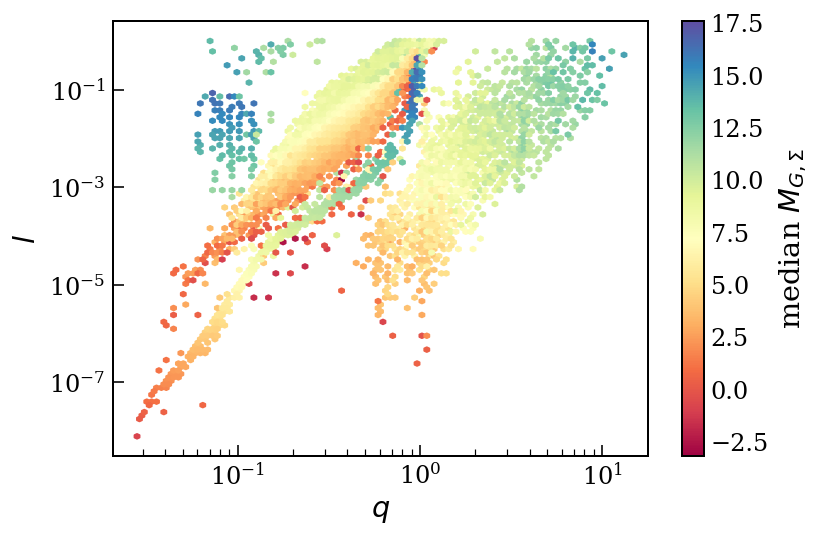

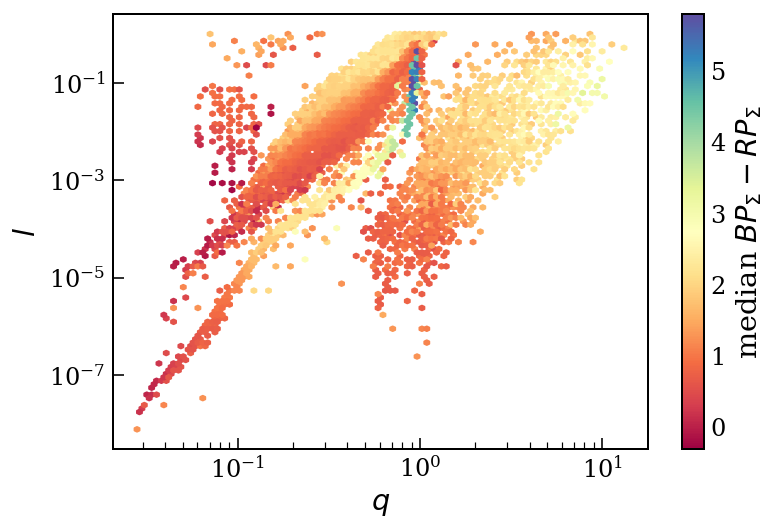

In [20]:
fig=plt.figure(figsize=(8,6))
ax=plt.gca()
im=ax.hexbin(uqs,uls,C=fuwes[fbinaries],reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral',bins='log',gridsize=64)
plt.colorbar(im,label='median UWE')
ax.set_ylabel(r'$l$')
ax.set_xlabel(r'$q$')
plt.show()

ax=plt.gca()
im=ax.hexbin(uqs,uls,C=uamags,reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral')
plt.colorbar(im,label='median $M_{G,\Sigma}$')
ax.set_ylabel(r'$l$')
ax.set_xlabel(r'$q$')
plt.show()

ax=plt.gca()
im=ax.hexbin(uqs,uls,C=ucols,reduce_C_function=np.median,
             xscale='log',yscale='log',cmap='Spectral')
plt.colorbar(im,label='median $BP_{\Sigma}-RP_{\Sigma}$')
ax.set_ylabel(r'$l$')
ax.set_xlabel(r'$q$')
plt.show()

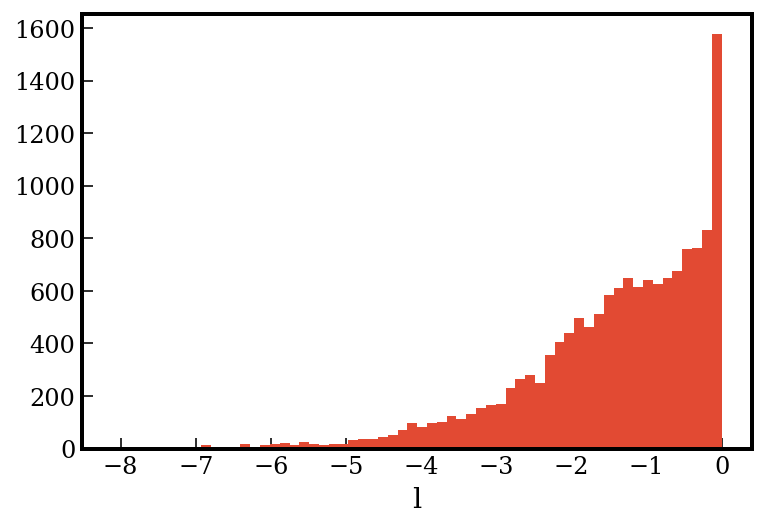

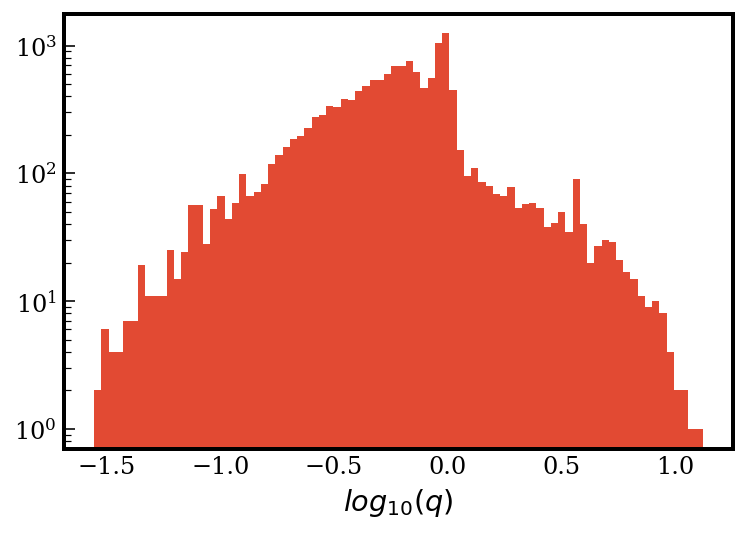

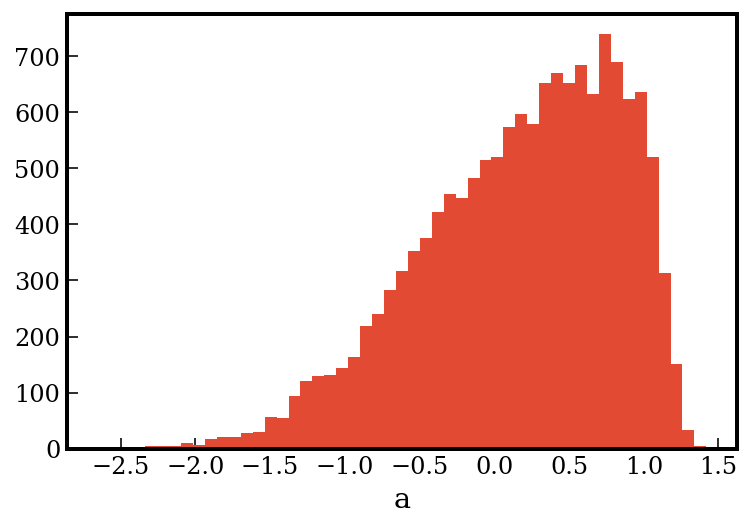

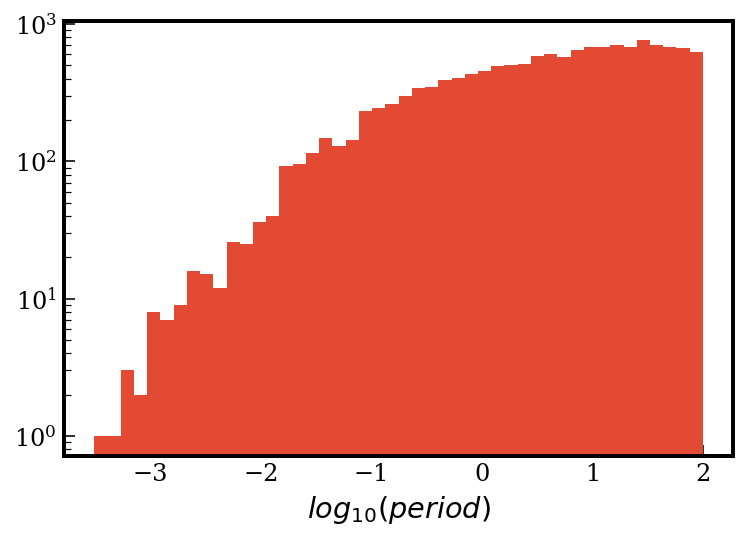

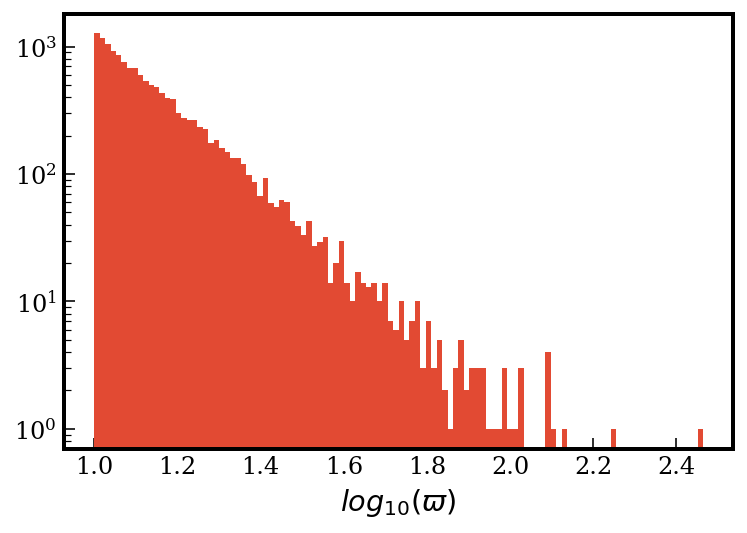

In [55]:
ax=plt.gca()
ax.hist(np.log10(uls),bins='auto')
ax.set_xlabel('l')
plt.show()
ax=plt.gca()
ax.hist(np.log10(uqs),bins='auto')
ax.set_yscale('log')
ax.set_xlabel(r'$log_{10}(q)$')
plt.show()
ax=plt.gca()
ax.hist(np.log10(uas),bins='auto')
ax.set_xlabel('a')
plt.show()
ax=plt.gca()
ax.hist(np.log10(uperiods),bins='auto')
ax.set_yscale('log')
ax.set_xlabel(r'$log_{10}(period)$')
plt.show()

ax=plt.gca()
ax.hist(np.log10(upllxs),bins='auto')
ax.set_yscale('log')
ax.set_xlabel(r'$log_{10}(\varpi)$')
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

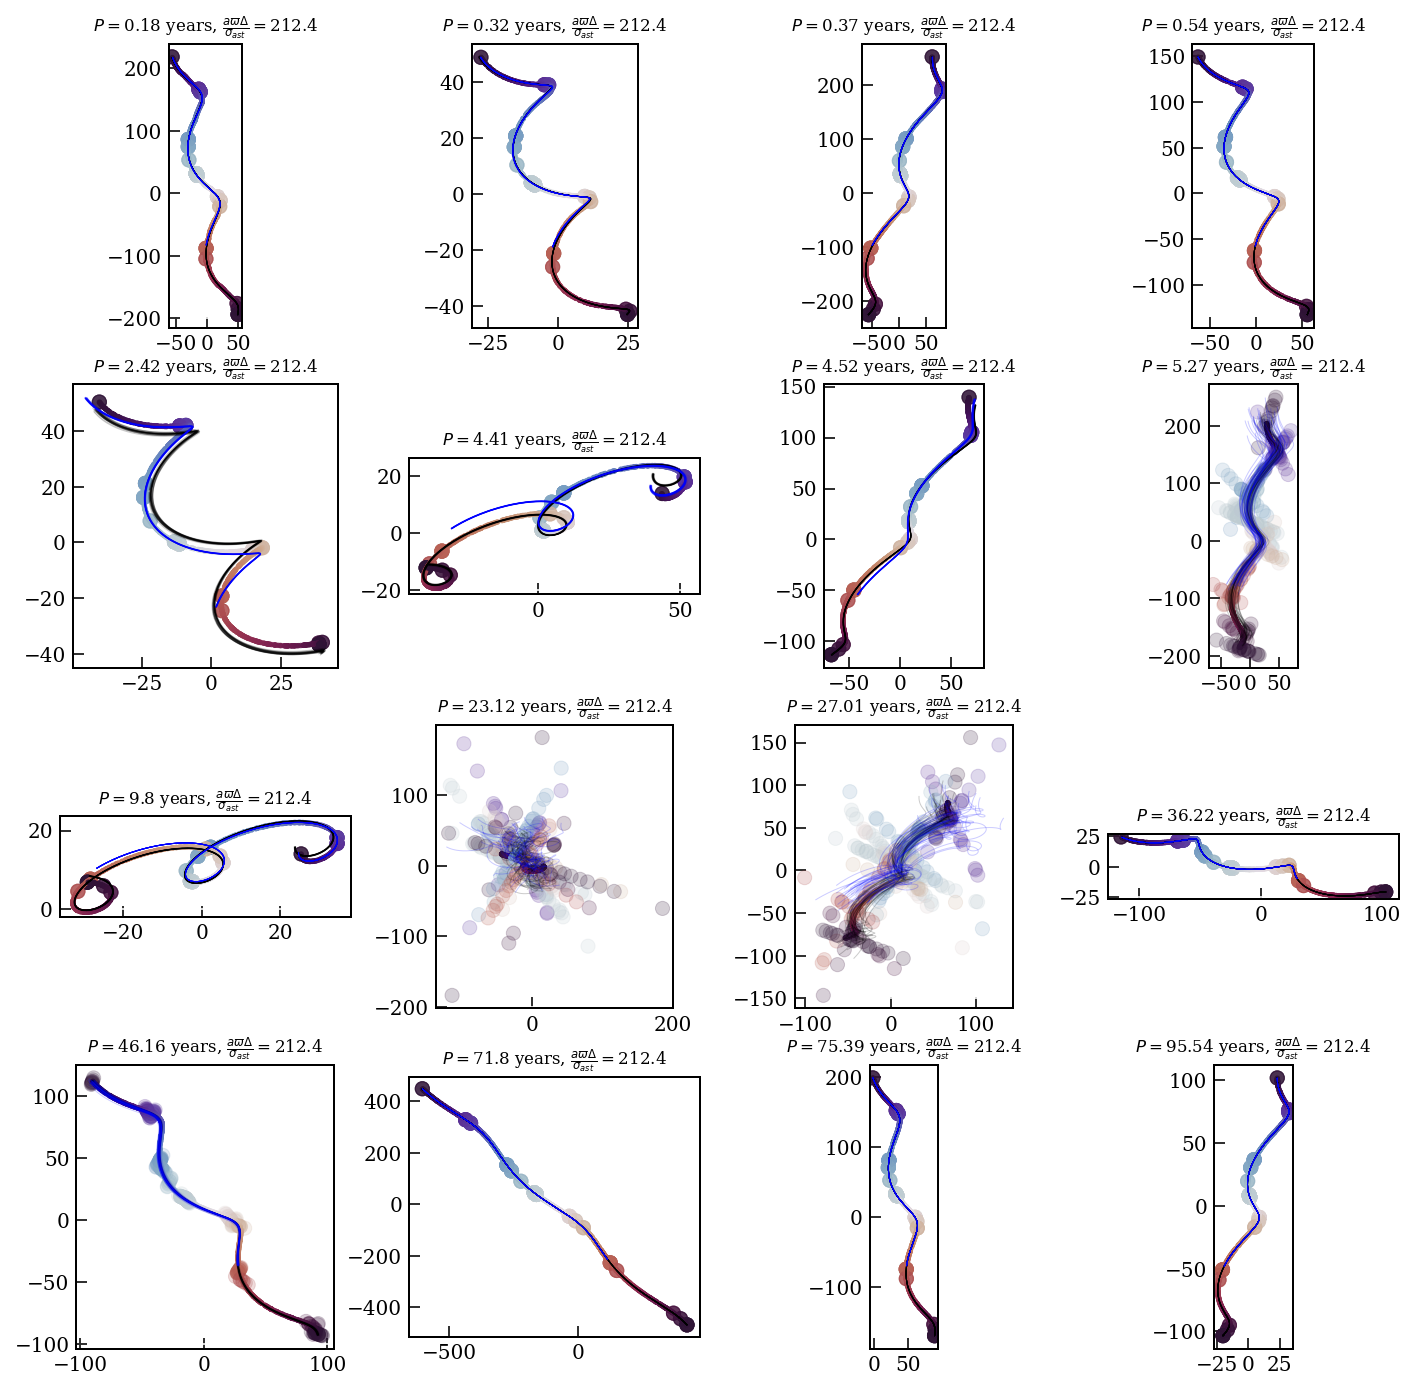

In [71]:
fig=plt.figure(figsize=(12,12))
grid=mpl.gridspec.GridSpec(4,4)

sel=np.argsort(uperiods[:16])
nrand=128

for i in tqdm(range(16)):
    ax=plt.subplot(grid[int(i/4),i%4])
    
    xvals=np.zeros(nrand)
    yvals=np.zeros(nrand)
    
    params=astromet.params()
    
    params.parallax=upllxs[sel[i]]
    params.pmrac=upmras[sel[i]]
    params.pmdec=upmdecs[sel[i]]

    params.period=uperiods[sel[i]]
    params.a=uas[sel[i]]
    params.e=ues[sel[i]]

    params.l=uls[sel[i]]
    params.q=uqs[sel[i]]

    params.vtheta=uvthetas[sel[i]]
    params.vphi=uvphis[sel[i]]
    params.vomega=uvomegas[sel[i]]

    params.tperi=utperis[sel[i]]

    alError=astromet.sigma_ast(umags[sel[i]])
    
    c=Source(params.ra,params.dec,unit='deg')
    sl=dr3_sl(c, return_times=True, return_angles=True)
    ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
    sort=np.argsort(ts)
    ts=ts[sort]

    phis=np.squeeze(np.hstack(sl['angles']))[sort]
    
    trueRacs,trueDecs=astromet.track(ts,params)

    t_obs,x_obs,phi_obs,rac_obs,dec_obs=astromet.mock_obs(ts,phis,trueRacs,trueDecs,err=alError)

    fitresults=astromet.fit(t_obs,x_obs,phi_obs,alError,params.ra,params.dec)

    indr2=np.flatnonzero(t_obs<astromet.tbegin+22/12)

    fitresults2=astromet.fit(t_obs[indr2],x_obs[indr2],phi_obs[indr2],alError,params.ra,params.dec)
        
    
    plotts=np.sort(ts[0]+(ts[-1]-ts[0])*np.random.rand(1000))
    plotRacs,plotDecs=astromet.track(plotts,params)
    
    fitparams=astromet.params()
    for j in range(32):
        fitparams.ra=params.ra
        fitparams.dec=params.dec
        fitparams.drac=fitresults['drac']+np.random.randn()*fitresults['drac_error']
        fitparams.ddec=fitresults['ddec']+np.random.randn()*fitresults['ddec_error']
        fitparams.pmrac=fitresults['pmrac']+np.random.randn()*fitresults['pmrac_error']
        fitparams.pmdec=fitresults['pmdec']+np.random.randn()*fitresults['pmdec_error']
        fitparams.parallax=fitresults['parallax']+np.random.randn()*fitresults['parallax_error']
        
        fitRacs,fitDecs=astromet.track(plotts,fitparams)
        ax.plot(fitRacs,fitDecs,c='k',alpha=0.2,lw=0.5)
    for j in range(32):
        fitparams.ra=params.ra
        fitparams.dec=params.dec
        fitparams.drac=fitresults2['drac']+np.random.randn()*fitresults2['drac_error']
        fitparams.ddec=fitresults2['ddec']+np.random.randn()*fitresults2['ddec_error']
        fitparams.pmrac=fitresults2['pmrac']+np.random.randn()*fitresults2['pmrac_error']
        fitparams.pmdec=fitresults2['pmdec']+np.random.randn()*fitresults2['pmdec_error']
        fitparams.parallax=fitresults2['parallax']+np.random.randn()*fitresults2['parallax_error']
        
        fitRacs,fitDecs=astromet.track(plotts[plotts<astromet.tbegin+22/12],
                                       fitparams)
        ax.plot(fitRacs,fitDecs,c='b',alpha=0.2,lw=0.5)
    ax.scatter(rac_obs,dec_obs,c=t_obs,alpha=0.2,s=50,cmap='twilight_shifted')
    ax.scatter(plotRacs,plotDecs,c=plotts,s=5,alpha=0.8,cmap='twilight_shifted')
    
    title=r'$P=$'+str(np.round(params.period,2))+\
        r' years, $\frac{a \varpi \Delta}{\sigma_{ast}}=$'+str(np.round(binsig,2))
    ax.set_aspect('equal')
    ax.set_title(title,fontsize='small')
    
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

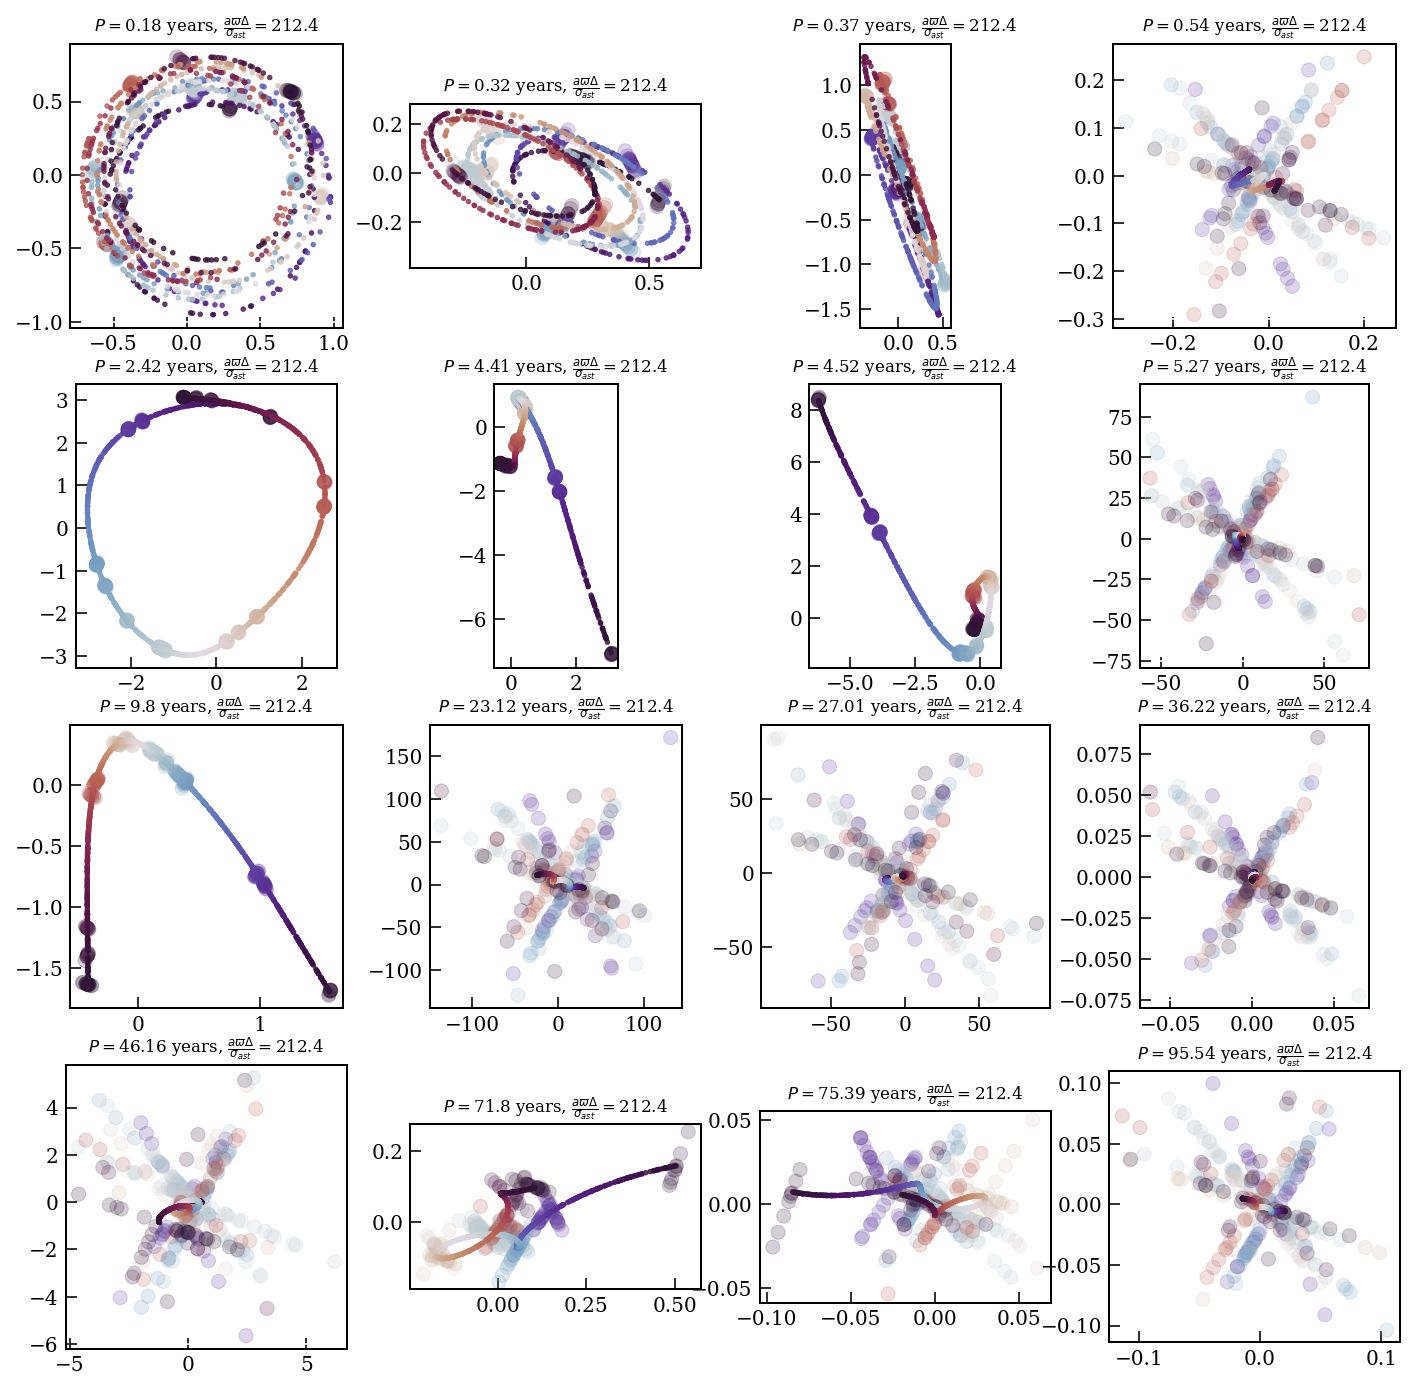

In [72]:
fig=plt.figure(figsize=(12,12))
grid=mpl.gridspec.GridSpec(4,4)

sel=np.argsort(uperiods[:16])
nrand=128

for i in tqdm(range(16)):
    ax=plt.subplot(grid[int(i/4),i%4])
    
    xvals=np.zeros(nrand)
    yvals=np.zeros(nrand)
    
    params=astromet.params()
    
    params.parallax=upllxs[sel[i]]
    params.pmrac=upmras[sel[i]]
    params.pmdec=upmdecs[sel[i]]

    params.period=uperiods[sel[i]]
    params.a=uas[sel[i]]
    params.e=ues[sel[i]]

    params.l=uls[sel[i]]
    params.q=uqs[sel[i]]

    params.vtheta=uvthetas[sel[i]]
    params.vphi=uvphis[sel[i]]
    params.vomega=uvomegas[sel[i]]

    params.tperi=utperis[sel[i]]

    alError=astromet.sigma_ast(umags[sel[i]])
    
    c=Source(params.ra,params.dec,unit='deg')
    sl=dr3_sl(c, return_times=True, return_angles=True)
    ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
    sort=np.argsort(ts)
    ts=ts[sort]

    phis=np.squeeze(np.hstack(sl['angles']))[sort]
    
    trueRacs,trueDecs=astromet.track(ts,params)

    t_obs,x_obs,phi_obs,rac_obs,dec_obs=astromet.mock_obs(ts,phis,trueRacs,trueDecs,err=alError)

    fitresults=astromet.fit(t_obs,x_obs,phi_obs,alError,params.ra,params.dec)

    indr2=np.flatnonzero(t_obs<astromet.tbegin+22/12)

    fitresults2=astromet.fit(t_obs[indr2],x_obs[indr2],phi_obs[indr2],alError,params.ra,params.dec)
        
    
    plotts=np.sort(ts[0]+(ts[-1]-ts[0])*np.random.rand(1000))
    plotRacs,plotDecs=astromet.track(plotts,params)
    
    fitparams=astromet.params()
    
    fitparams.ra=params.ra
    fitparams.dec=params.dec
    fitparams.drac=fitresults['drac']
    fitparams.ddec=fitresults['ddec']
    fitparams.pmrac=fitresults['pmrac']
    fitparams.pmdec=fitresults['pmdec']
    fitparams.parallax=fitresults['parallax']
        
    fitRacs,fitDecs=astromet.track(plotts,fitparams)
    rac_fit,dec_fit=astromet.track(t_obs,fitparams)
    
    ax.scatter(rac_obs-rac_fit,dec_obs-dec_fit,c=t_obs,alpha=0.2,s=50,cmap='twilight_shifted')
    ax.scatter(plotRacs-fitRacs,plotDecs-fitDecs,c=plotts,s=5,alpha=0.8,cmap='twilight_shifted')
    
    title=r'$P=$'+str(np.round(params.period,2))+\
        r' years, $\frac{a \varpi \Delta}{\sigma_{ast}}=$'+str(np.round(binsig,2))
    ax.set_aspect('equal')
    ax.set_title(title,fontsize='small')
    
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

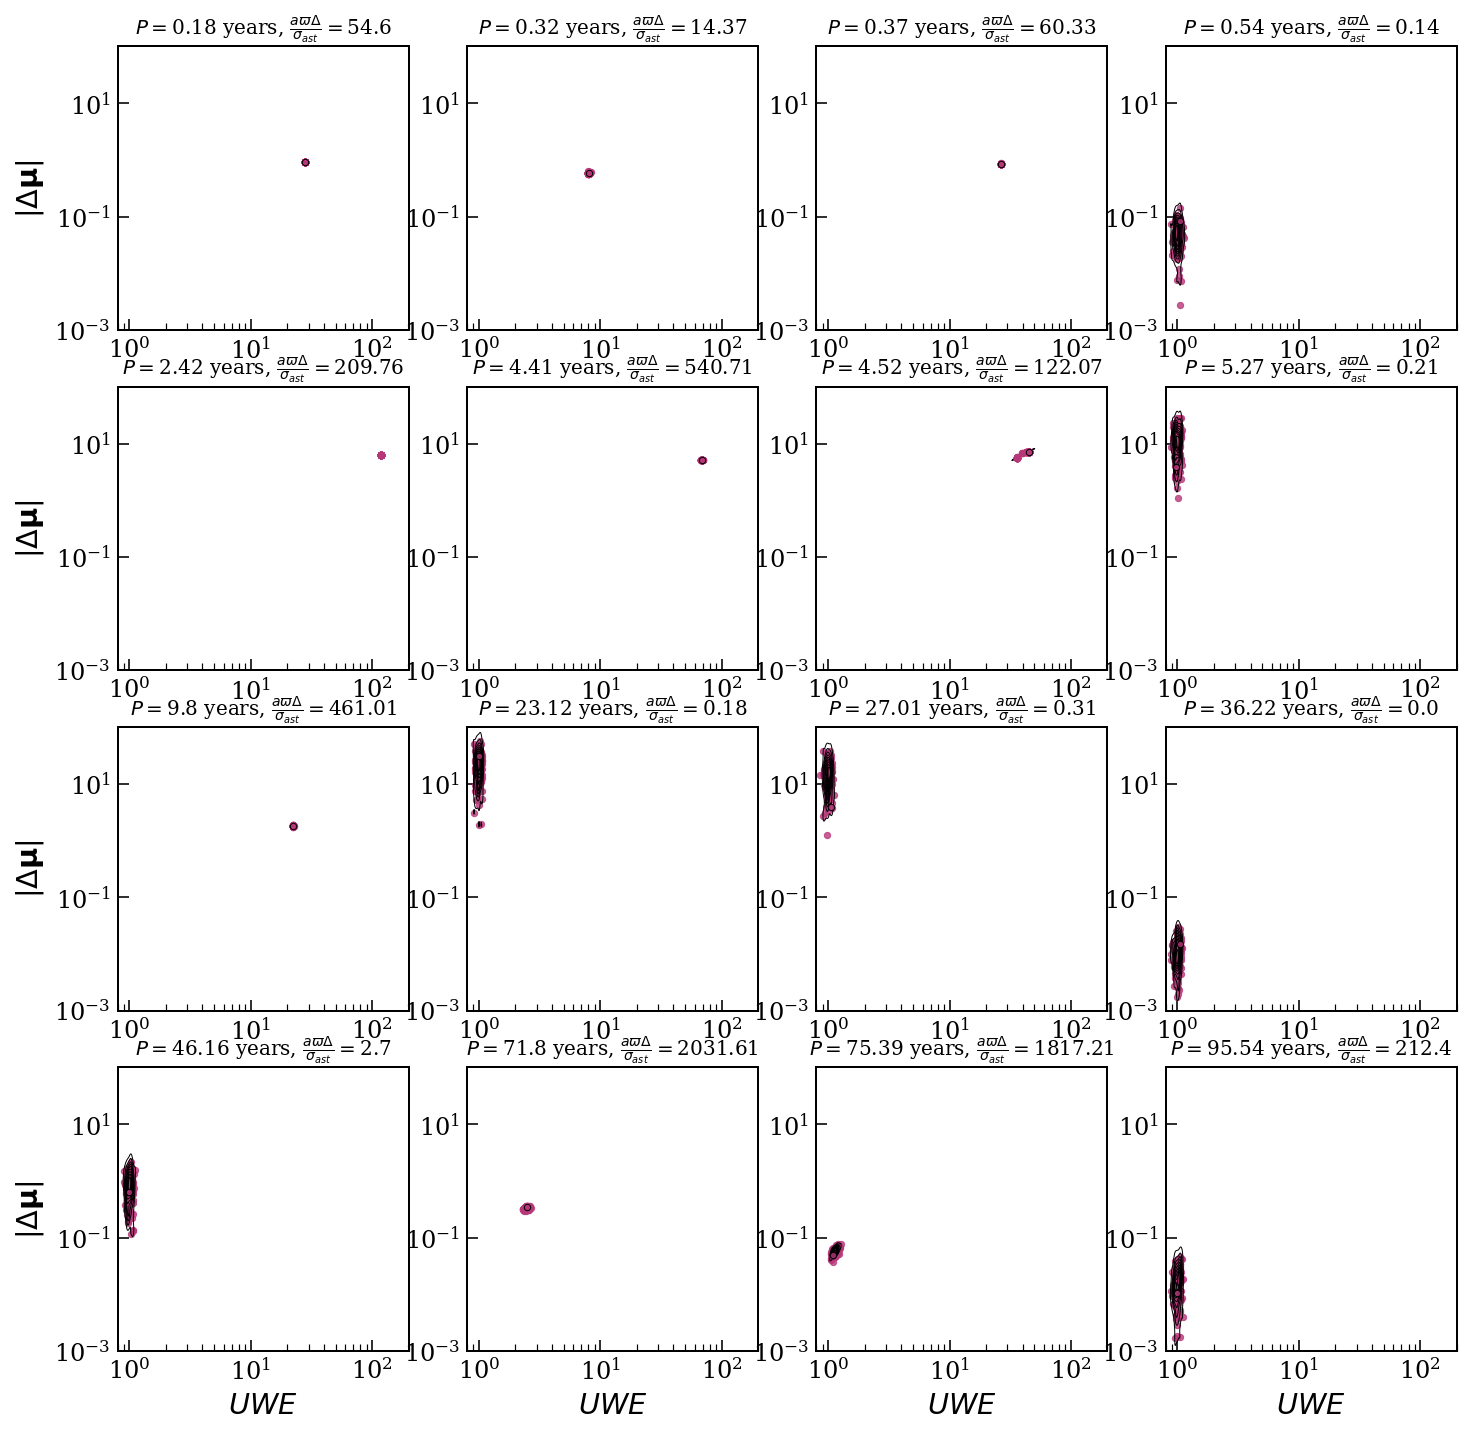

In [60]:
fig=plt.figure(figsize=(12,12))
grid=mpl.gridspec.GridSpec(4,4)

sel=np.argsort(uperiods[:16])
nrand=128

for i in tqdm(range(16)):
    ax=plt.subplot(grid[int(i/4),i%4])
    
    xvals=np.zeros(nrand)
    yvals=np.zeros(nrand)
    
    params=astromet.params()
    
    params.parallax=upllxs[sel[i]]
    params.pmrac=upmras[sel[i]]
    params.pmdec=upmdecs[sel[i]]

    params.period=uperiods[sel[i]]
    params.a=uas[sel[i]]
    params.e=ues[sel[i]]

    params.l=uls[sel[i]]
    params.q=uqs[sel[i]]

    params.vtheta=uvthetas[sel[i]]
    params.vphi=uvphis[sel[i]]
    params.vomega=uvomegas[sel[i]]

    params.tperi=utperis[sel[i]]

    alError=astromet.sigma_ast(umags[sel[i]])
    
    c=Source(params.ra,params.dec,unit='deg')
    sl=dr3_sl(c, return_times=True, return_angles=True)
    ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
    sort=np.argsort(ts)
    ts=ts[sort]

    phis=np.squeeze(np.hstack(sl['angles']))[sort]
    
    for j in range(nrand):

        trueRacs,trueDecs=astromet.track(ts,params)

        t_obs,x_obs,phi_obs,rac_obs,dec_obs=astromet.mock_obs(ts,phis,trueRacs,trueDecs,err=alError)

        fitresults=astromet.fit(t_obs,x_obs,phi_obs,alError,params.ra,params.dec)

        indr2=np.flatnonzero(t_obs<astromet.tbegin+22/12)

        fitresults2=astromet.fit(t_obs[indr2],x_obs[indr2],phi_obs[indr2],alError,params.ra,params.dec)
        
        uwe3=fitresults['UWE']
        duwe=uwe3-fitresults2['UWE']
        dpmrac=fitresults['pmrac']-fitresults2['pmrac']
        dpmdec=fitresults['pmdec']-fitresults2['pmdec']
        dpm=np.sqrt(dpmrac**2 + dpmdec**2)
        
        xvals[j]=uwe3
        yvals[j]=dpm
        
        col=np.array(mpl.cm.magma(fitresults2['vis_periods']/20))
        col[3]=0.8
        ecol=None
        zorder=uwe3
        if j==0:
            ecol='k'
            zorder=100
        ax.scatter(uwe3,dpm,color=col,s=10,edgecolors=ecol,zorder=zorder)
    ax.set_xlim(0.8,200)
    ax.set_ylim(1e-3,100)
    ax.set_xscale('log')
    ax.set_yscale('log')
    binsig=astromet.Delta(params)*params.a*params.parallax/alError
    title=r'$P=$'+str(np.round(params.period,2))+\
        r' years, $\frac{a \varpi \Delta}{\sigma_{ast}}=$'+str(np.round(binsig,2))
    
    ax.set_title(title,fontsize='small')
    if int(i/4)==3:
        ax.set_xlabel(r'$UWE$')
    else:
        ax.set_xlabel('')
        ax.set_xticklabels([])
    if i%4==0:
        ax.set_ylabel(r'$|\Delta \mathbf{\mu}|$')
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    sns.kdeplot(x=xvals,y=yvals,ax=ax,linewidths=0.5,color='k',log_scale=True)
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

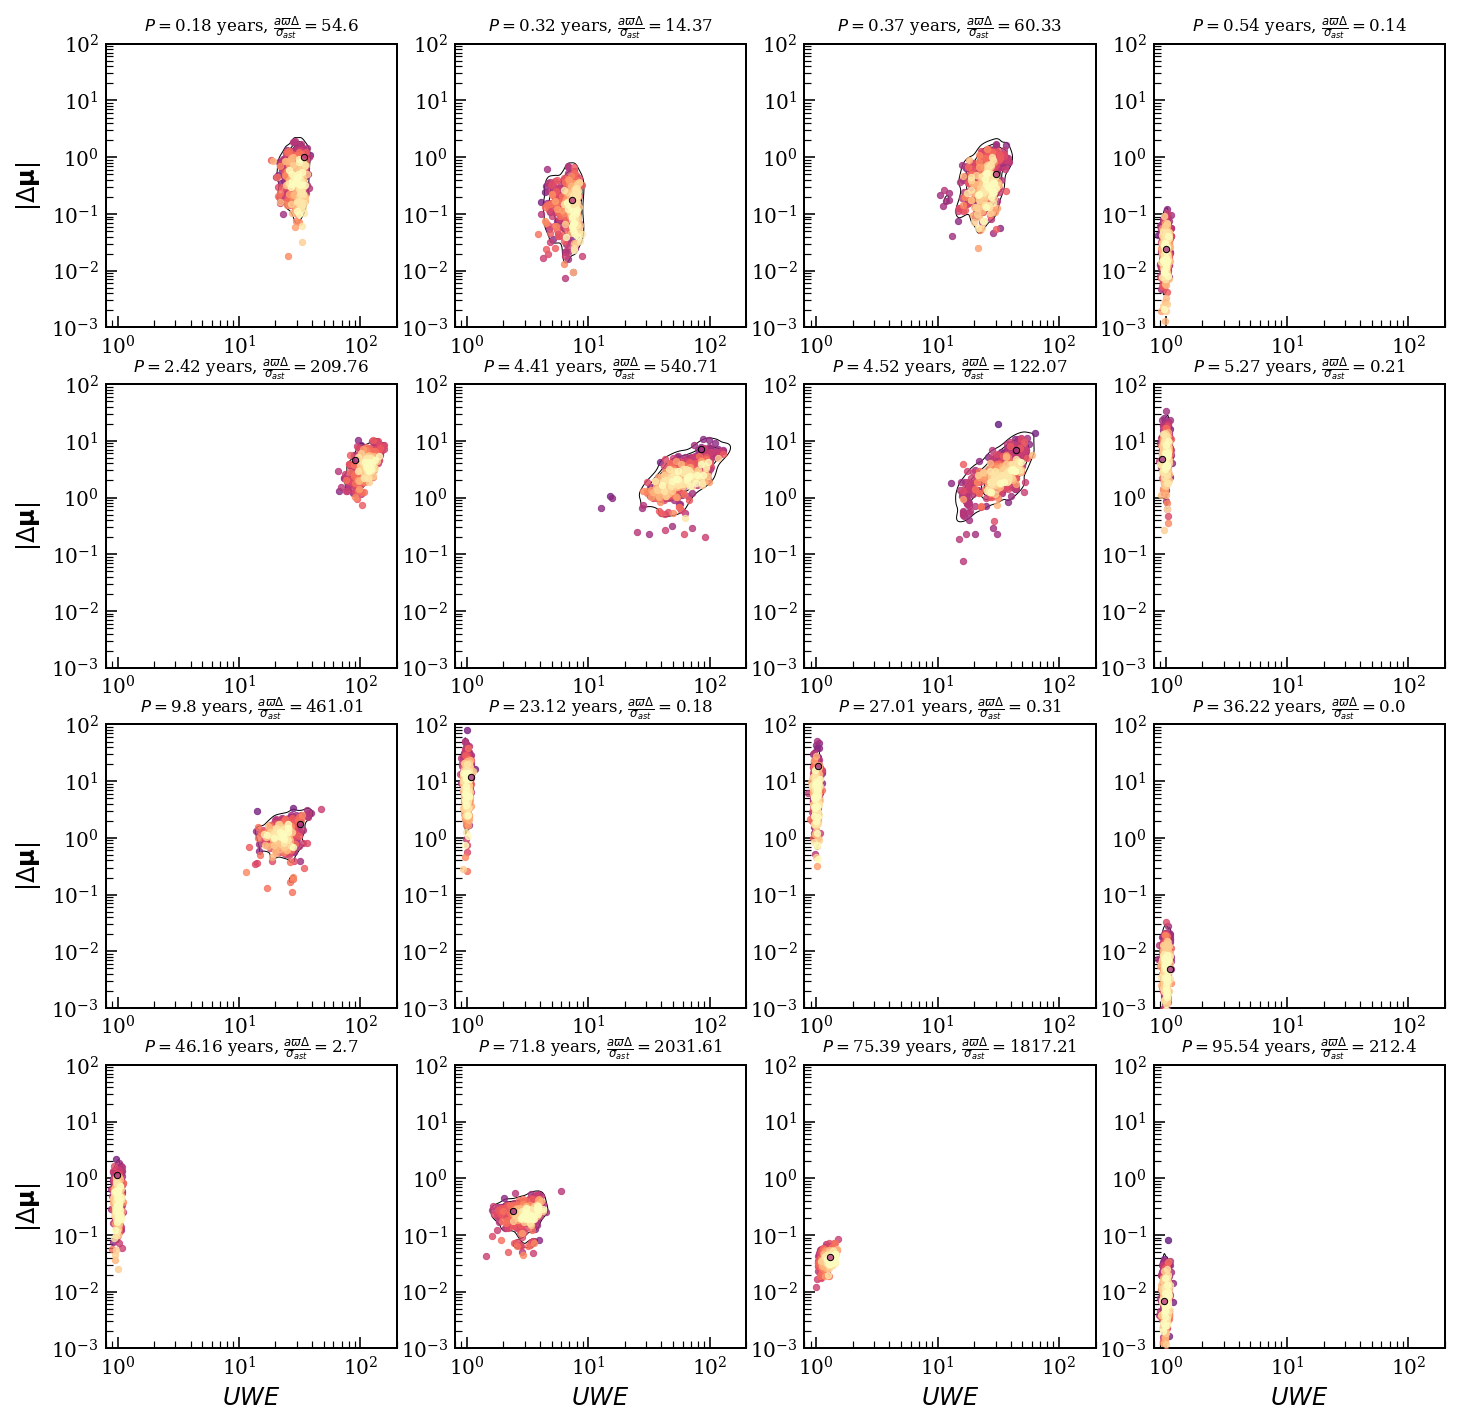

In [73]:
fig=plt.figure(figsize=(12,12))
grid=mpl.gridspec.GridSpec(4,4)

sel=np.argsort(uperiods[:16])
nrand=512

for i in tqdm(range(16)):
    ax=plt.subplot(grid[int(i/4),i%4])
    
    xvals=np.zeros(nrand)
    yvals=np.zeros(nrand)
    
    params=astromet.params()
    
    params.parallax=upllxs[sel[i]]
    params.pmrac=upmras[sel[i]]
    params.pmdec=upmdecs[sel[i]]

    params.period=uperiods[sel[i]]
    params.a=uas[sel[i]]
    params.e=ues[sel[i]]

    params.l=uls[sel[i]]
    params.q=uqs[sel[i]]

    params.vtheta=uvthetas[sel[i]]
    params.vphi=uvphis[sel[i]]
    params.vomega=uvomegas[sel[i]]

    params.tperi=utperis[sel[i]]

    alError=astromet.sigma_ast(umags[sel[i]])
    
    for j in range(nrand):
        if j==0:
            params.ra=uras[sel[i]]
            params.dec=udecs[sel[i]]
        else:
            params.ra=360*np.random.rand()
            params.dec=np.arcsin(-1+2*np.random.rand())*180/np.pi
            
        c=Source(params.ra,params.dec,unit='deg')
        sl=dr3_sl(c, return_times=True, return_angles=True)
        ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
        sort=np.argsort(ts)
        ts=ts[sort]

        phis=np.squeeze(np.hstack(sl['angles']))[sort]
        
        params.ra=uras[sel[i]]
        params.dec=udecs[sel[i]]

        trueRacs,trueDecs=astromet.track(ts,params)

        t_obs,x_obs,phi_obs,rac_obs,dec_obs=astromet.mock_obs(ts,phis,trueRacs,trueDecs,err=alError)

        fitresults=astromet.fit(t_obs,x_obs,phi_obs,alError,params.ra,params.dec)

        indr2=np.flatnonzero(t_obs<astromet.tbegin+22/12)

        fitresults2=astromet.fit(t_obs[indr2],x_obs[indr2],phi_obs[indr2],alError,params.ra,params.dec)
        
        uwe3=fitresults['UWE']
        duwe=uwe3-fitresults2['UWE']
        dpmrac=fitresults['pmrac']-fitresults2['pmrac']
        dpmdec=fitresults['pmdec']-fitresults2['pmdec']
        dpm=np.sqrt(dpmrac**2 + dpmdec**2)
        
        xvals[j]=uwe3
        yvals[j]=dpm
        
        col=np.array(mpl.cm.magma(fitresults2['vis_periods']/20))
        col[3]=0.8
        ecol=None
        zorder=fitresults2['vis_periods']
        if j==0:
            ecol='k'
            zorder=100
        ax.scatter(uwe3,dpm,color=col,s=10,edgecolors=ecol,zorder=zorder)
    ax.set_xlim(0.8,200)
    ax.set_ylim(1e-3,100)
    ax.set_xscale('log')
    ax.set_yscale('log')
    binsig=astromet.Delta(params)*params.a*params.parallax/alError
    title=r'$P=$'+str(np.round(params.period,2))+\
        r' years, $\frac{a \varpi \Delta}{\sigma_{ast}}=$'+str(np.round(binsig,2))
    
    ax.set_title(title,fontsize='small')
    if int(i/4)==3:
        ax.set_xlabel(r'$UWE$')
    else:
        ax.set_xlabel('')
        ax.set_xticklabels([])
    if i%4==0:
        ax.set_ylabel(r'$|\Delta \mathbf{\mu}|$')
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    sns.kdeplot(x=xvals,y=yvals,ax=ax,linewidths=0.5,color='k',log_scale=True)
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

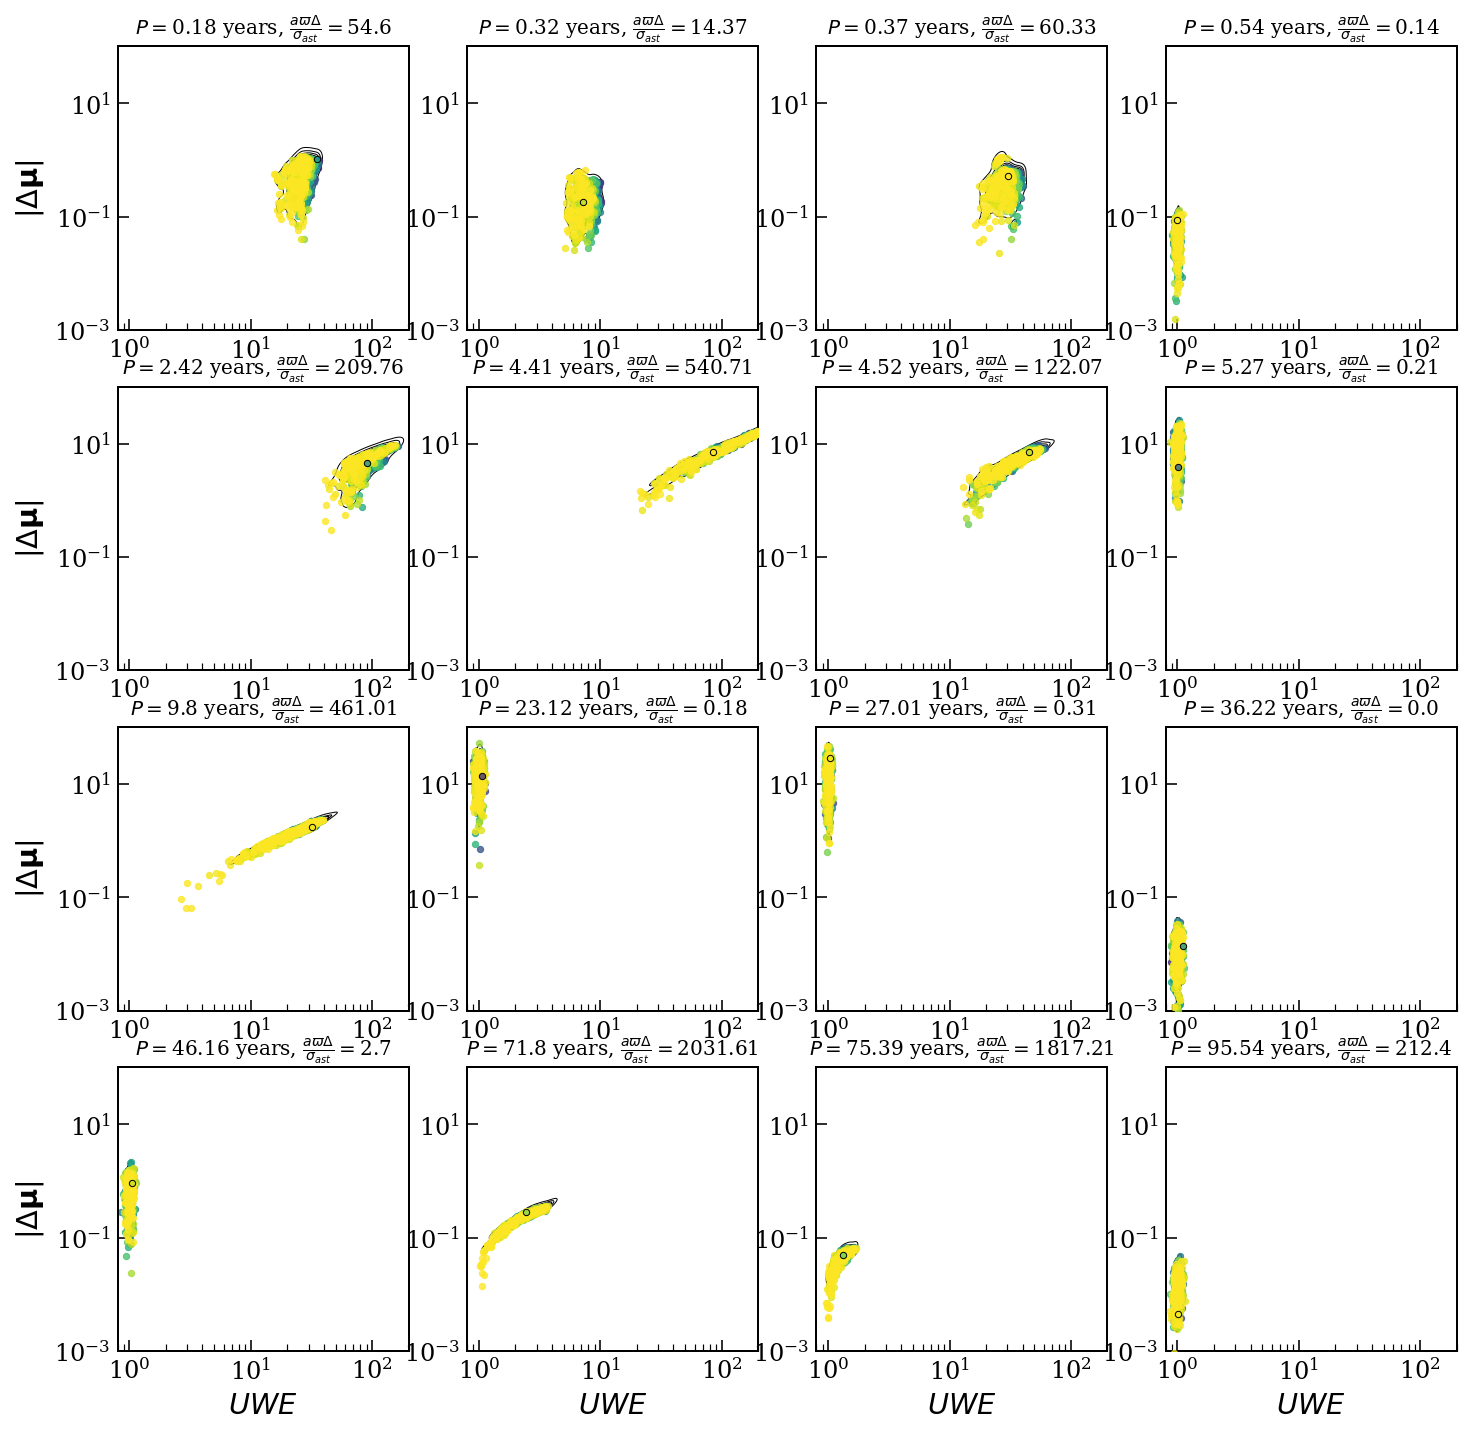

In [58]:
fig=plt.figure(figsize=(12,12))
grid=mpl.gridspec.GridSpec(4,4)

sel=np.argsort(uperiods[:16])
nrand=512

for i in tqdm(range(16)):
    ax=plt.subplot(grid[int(i/4),i%4])
    
    xvals=np.zeros(nrand)
    yvals=np.zeros(nrand)
    
    params=astromet.params()
    
    params.parallax=upllxs[sel[i]]
    params.pmrac=upmras[sel[i]]
    params.pmdec=upmdecs[sel[i]]

    params.period=uperiods[sel[i]]
    params.a=uas[sel[i]]
    params.e=ues[sel[i]]

    params.l=uls[sel[i]]
    params.q=uqs[sel[i]]

    params.ra=uras[sel[i]]
    params.dec=udecs[sel[i]]
    params.vtheta=uvthetas[sel[i]]
    params.vphi=uvphis[sel[i]]
    params.vomega=uvomegas[sel[i]]

    params.tperi=utperis[sel[i]]

    alError=astromet.sigma_ast(umags[sel[i]])
    
    c=Source(params.ra,params.dec,unit='deg')
    sl=dr3_sl(c, return_times=True, return_angles=True)
    ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
    sort=np.argsort(ts)
    ts=ts[sort]

    phis=np.squeeze(np.hstack(sl['angles']))[sort]
    
    for j in range(nrand):
        if j==0:
            params.vtheta=uvthetas[sel[i]]
            params.vphi=uvphis[sel[i]]
            params.vomega=uvomegas[sel[i]]
        else:
            params.vtheta=np.arccos(-1+2*np.random.rand())
            params.vphi=2*np.pi*np.random.rand()
            params.vomega=2*np.pi*np.random.rand()

        trueRacs,trueDecs=astromet.track(ts,params)

        t_obs,x_obs,phi_obs,rac_obs,dec_obs=astromet.mock_obs(ts,phis,trueRacs,trueDecs,err=alError)

        fitresults=astromet.fit(t_obs,x_obs,phi_obs,alError,params.ra,params.dec)

        indr2=np.flatnonzero(t_obs<astromet.tbegin+22/12)

        fitresults2=astromet.fit(t_obs[indr2],x_obs[indr2],phi_obs[indr2],alError,params.ra,params.dec)
        
        uwe3=fitresults['UWE']
        duwe=uwe3-fitresults2['UWE']
        dpmrac=fitresults['pmrac']-fitresults2['pmrac']
        dpmdec=fitresults['pmdec']-fitresults2['pmdec']
        dpm=np.sqrt(dpmrac**2 + dpmdec**2)
        
        xvals[j]=uwe3
        yvals[j]=dpm
        
        col=np.array(mpl.cm.viridis(np.sin(params.vtheta)))
        col[3]=0.8
        ecol=None
        zorder=2+np.sin(params.vtheta)
        if j==0:
            ecol='k'
            zorder=100
        ax.scatter(uwe3,dpm,color=col,s=10,edgecolors=ecol,zorder=zorder)
    ax.set_xlim(0.8,200)
    ax.set_ylim(1e-3,100)
    ax.set_xscale('log')
    ax.set_yscale('log')
    binsig=astromet.Delta(params)*params.a*params.parallax/alError
    title=r'$P=$'+str(np.round(params.period,2))+\
        r' years, $\frac{a \varpi \Delta}{\sigma_{ast}}=$'+str(np.round(binsig,2))
    
    ax.set_title(title,fontsize='small')
    if int(i/4)==3:
        ax.set_xlabel(r'$UWE$')
    else:
        ax.set_xlabel('')
        ax.set_xticklabels([])
    if i%4==0:
        ax.set_ylabel(r'$|\Delta \mathbf{\mu}|$')
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    sns.kdeplot(x=xvals,y=yvals,ax=ax,linewidths=0.5,color='k',log_scale=True)
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

---------------------------------------
ra, dec, pllx, pmrac, pmdec  268.5070921710447 -28.573252738830174 17.821058 -34.183548 -161.7722
period  5.2658439077472625
a  0.8464624285697937
e  0.5819171071052551
Delta  0.3935455888964898
UWE  0.9750319794512139


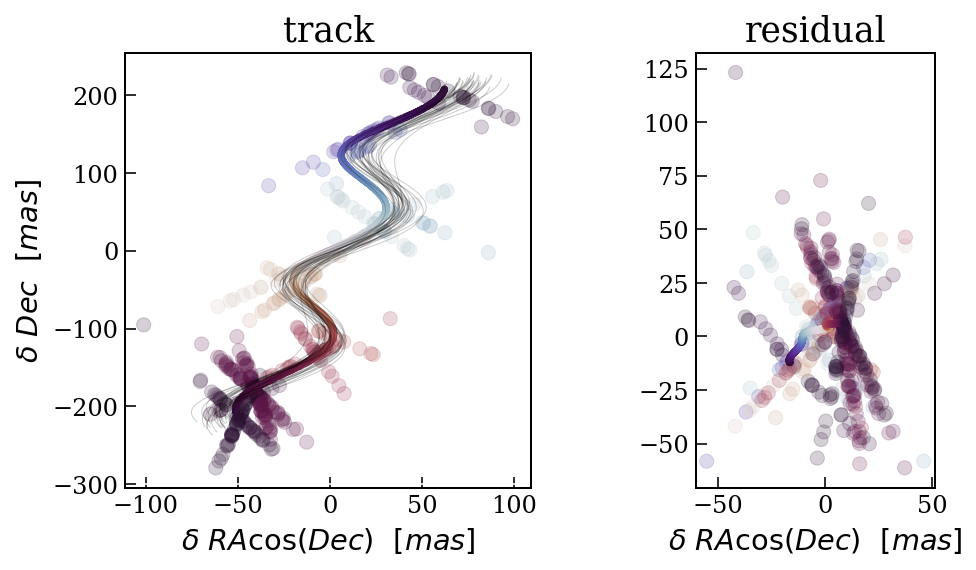

{'astrometric_matched_transits': 45, 'visibility_periods_used': 16, 'astrometric_n_obs_al': 405, 'astrometric_params_solved': 31, 'ra': 268.50708986572647, 'ra_error': 3.1358350837580367, 'dec': -28.57325258545038, 'dec_error': 2.829959787849549, 'ra_dec_corr': 0.1274159884203251, 'parallax': 20.112413097193837, 'parallax_error': 4.482573911868791, 'ra_parallax_corr': 0.046304775673622914, 'dec_parallax_corr': 0.5548695358224732, 'pmra': -38.764955108008536, 'pmra_error': 3.8668174035919622, 'ra_pmra_corr': -0.14939142295395755, 'dec_pmra_corr': 0.03162643384813369, 'parallax_pmra_corr': 0.24814688609498578, 'pmdec': -167.47456734719674, 'pmdec_error': 2.846747859796981, 'ra_pmdec_corr': -0.04421327215561677, 'dec_pmdec_corr': -0.7943546817525418, 'parallax_pmdec_corr': -0.5581763721930141, 'pmra_pmdec_corr': 0.1270543075518127, 'astrometric_excess_noise': 0.0, 'astrometric_chi2_al': 380.274944381021, 'astrometric_n_good_obs_al': 405, 'UWE': 0.9750319794512139}
------------------------

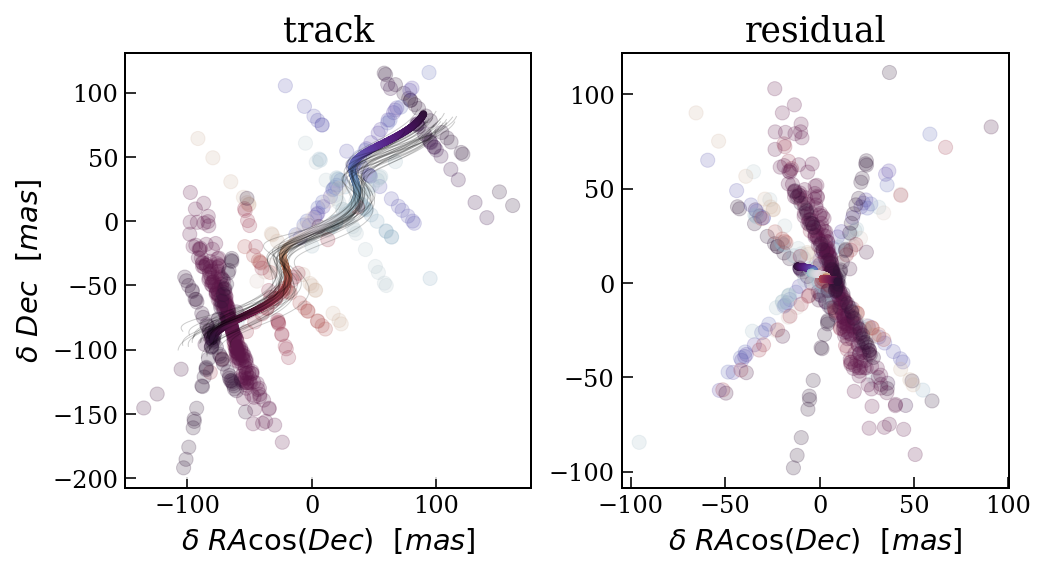

{'astrometric_matched_transits': 59, 'visibility_periods_used': 16, 'astrometric_n_obs_al': 531, 'astrometric_params_solved': 31, 'ra': 269.57153803068985, 'ra_error': 4.069426075927576, 'dec': -30.430661631340175, 'dec_error': 3.1374493694053207, 'ra_dec_corr': 0.32819133590074445, 'parallax': 15.146751554510516, 'parallax_error': 4.629196440047969, 'ra_parallax_corr': 0.015229720690494173, 'dec_parallax_corr': 0.28377348151983756, 'pmra': -62.215787775295944, 'pmra_error': 4.874649600088489, 'ra_pmra_corr': -0.022922359455077146, 'dec_pmra_corr': -0.05587070076338244, 'parallax_pmra_corr': 0.07348973355033549, 'pmdec': -63.9936702587959, 'pmdec_error': 3.268929845174405, 'ra_pmdec_corr': -0.04254774022995792, 'dec_pmdec_corr': -0.6525623089373376, 'parallax_pmdec_corr': -0.3713875023281986, 'pmra_pmdec_corr': 0.3865217529184241, 'astrometric_excess_noise': 0.0, 'astrometric_chi2_al': 507.6123686738455, 'astrometric_n_good_obs_al': 531, 'UWE': 0.9823657801429689}
---------------------

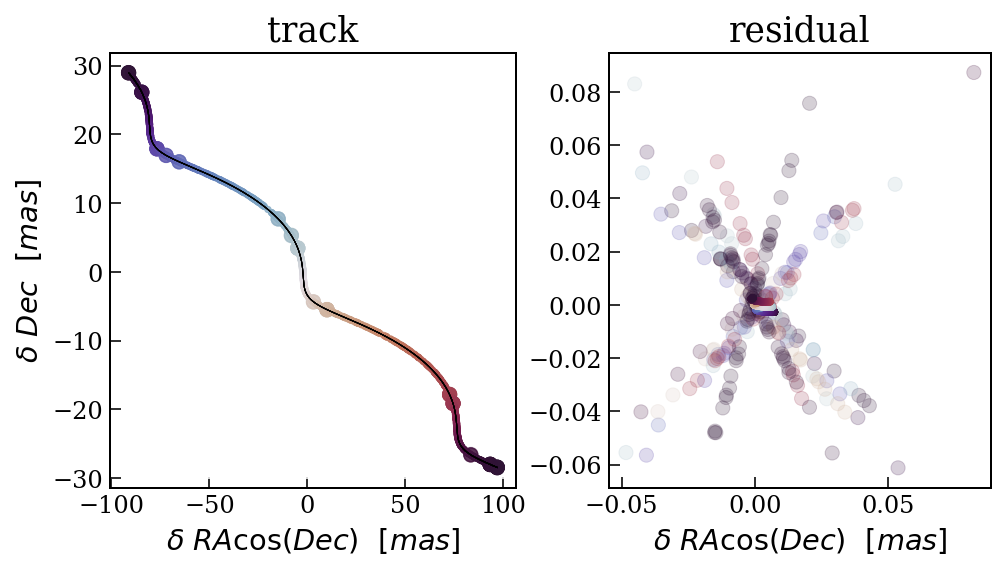

{'astrometric_matched_transits': 28, 'visibility_periods_used': 14, 'astrometric_n_obs_al': 252, 'astrometric_params_solved': 31, 'ra': 270.66461959548604, 'ra_error': 0.0038585879844323647, 'dec': -30.288825581437877, 'dec_error': 0.003065104258210797, 'ra_dec_corr': 0.2619907169690871, 'parallax': 11.39607672134596, 'parallax_error': 0.004582166580326577, 'ra_parallax_corr': 0.15301017458617777, 'dec_parallax_corr': 0.33542759754850066, 'pmra': 78.48569179533627, 'pmra_error': 0.004379419519260679, 'ra_pmra_corr': 0.030831315146746002, 'dec_pmra_corr': -0.16507902242616182, 'parallax_pmra_corr': 0.20657499578531482, 'pmdec': -21.903431409589267, 'pmdec_error': 0.0031380284842609605, 'ra_pmdec_corr': -0.24953433728883165, 'dec_pmdec_corr': -0.5281232368234356, 'parallax_pmdec_corr': -0.4292679540929036, 'pmra_pmdec_corr': 0.1739916087561254, 'astrometric_excess_noise': 0.0, 'astrometric_chi2_al': 226.23606337097888, 'astrometric_n_good_obs_al': 252, 'UWE': 0.957045181396747}
---------

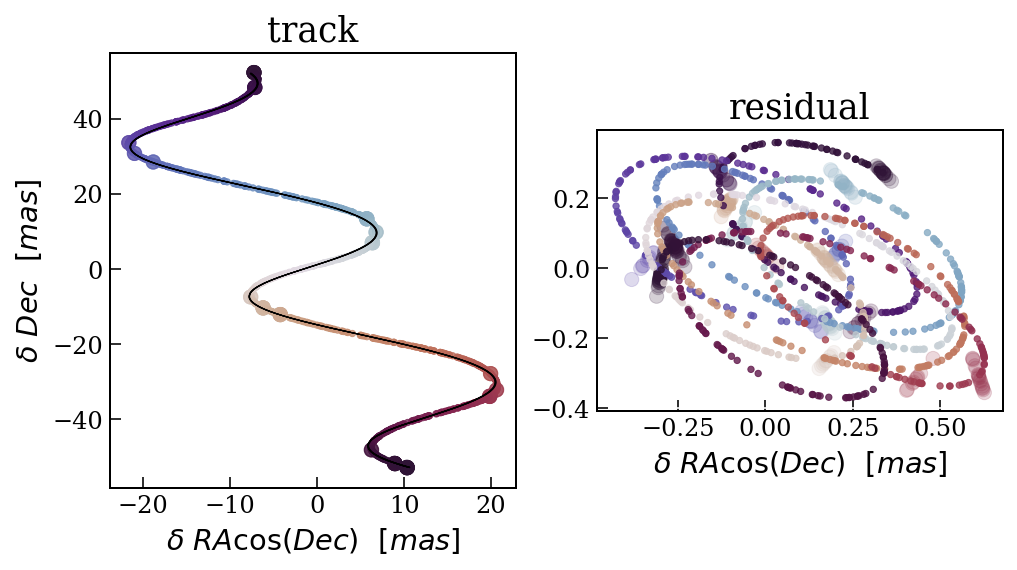

{'astrometric_matched_transits': 30, 'visibility_periods_used': 16, 'astrometric_n_obs_al': 270, 'astrometric_params_solved': 31, 'ra': 269.21204222410796, 'ra_error': 0.019538850543347887, 'dec': -25.873794079160792, 'dec_error': 0.016238323080613494, 'ra_dec_corr': 0.35232128086671205, 'parallax': 10.371557353458687, 'parallax_error': 0.023328628098003977, 'ra_parallax_corr': 0.14719766569448364, 'dec_parallax_corr': 0.38064380758709365, 'pmra': 13.648508154745585, 'pmra_error': 0.024403354205415687, 'ra_pmra_corr': -0.0408377510811063, 'dec_pmra_corr': -0.20031814244622284, 'parallax_pmra_corr': 0.2509558159442263, 'pmdec': -39.79377878755483, 'pmdec_error': 0.016627862785864582, 'ra_pmdec_corr': -0.29195380252855424, 'dec_pmdec_corr': -0.5701980852756393, 'parallax_pmdec_corr': -0.3496459272825447, 'pmra_pmdec_corr': 0.3080997476894927, 'astrometric_excess_noise': 0.1631903746284134, 'astrometric_chi2_al': 14149.6153878976, 'astrometric_n_good_obs_al': 270, 'UWE': 7.307172849239998

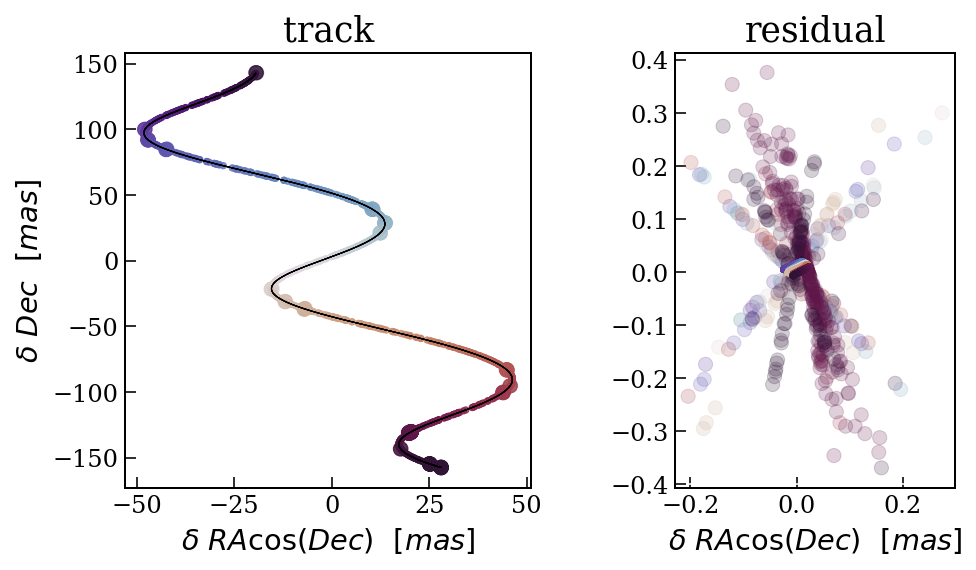

{'astrometric_matched_transits': 55, 'visibility_periods_used': 16, 'astrometric_n_obs_al': 495, 'astrometric_params_solved': 31, 'ra': 268.6456034159358, 'ra_error': 0.01485947956259575, 'dec': -27.62080187833962, 'dec_error': 0.011509146944112068, 'ra_dec_corr': 0.14565971341430134, 'parallax': 21.81206915842631, 'parallax_error': 0.016260940091216255, 'ra_parallax_corr': 0.10725646812233305, 'dec_parallax_corr': 0.2103865994477401, 'pmra': 32.69795029118589, 'pmra_error': 0.019304882162902146, 'ra_pmra_corr': -0.1415708399566541, 'dec_pmra_corr': 0.041741372191488386, 'parallax_pmra_corr': 0.06526514850740586, 'pmdec': -118.61544422629493, 'pmdec_error': 0.01170115998695713, 'ra_pmdec_corr': 0.035785835174188915, 'dec_pmdec_corr': -0.7374494522838124, 'parallax_pmdec_corr': -0.2567984746116318, 'pmra_pmdec_corr': 0.26135516203707554, 'astrometric_excess_noise': 0.0, 'astrometric_chi2_al': 533.1857008481595, 'astrometric_n_good_obs_al': 495, 'UWE': 1.0431366561307251}
---------------

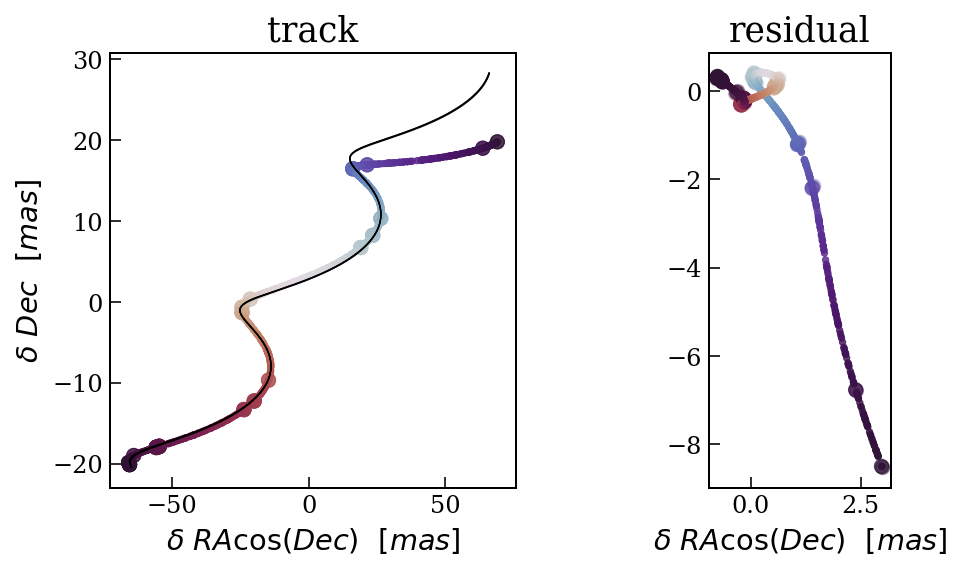

{'astrometric_matched_transits': 45, 'visibility_periods_used': 16, 'astrometric_n_obs_al': 405, 'astrometric_params_solved': 31, 'ra': 268.7328069579174, 'ra_error': 0.040579060646959715, 'dec': -28.835974235701546, 'dec_error': 0.034482368479803745, 'ra_dec_corr': -0.39012536548219057, 'parallax': 14.256451008028368, 'parallax_error': 0.04161011888574216, 'ra_parallax_corr': -0.22787468238472944, 'dec_parallax_corr': 0.40648969211568786, 'pmra': -40.2109190944755, 'pmra_error': 0.053133917075068926, 'ra_pmra_corr': -0.5668870622534411, 'dec_pmra_corr': 0.4466089382332332, 'parallax_pmra_corr': 0.3487562683305024, 'pmdec': -18.768517538248467, 'pmdec_error': 0.03395718401964591, 'ra_pmdec_corr': 0.42348490618021706, 'dec_pmdec_corr': -0.8598373985304002, 'parallax_pmdec_corr': -0.4442128642145808, 'pmra_pmdec_corr': -0.296486922641609, 'astrometric_excess_noise': 0.27487184964092193, 'astrometric_chi2_al': 2720959.78685254, 'astrometric_n_good_obs_al': 387, 'UWE': 84.3974607390242}
--

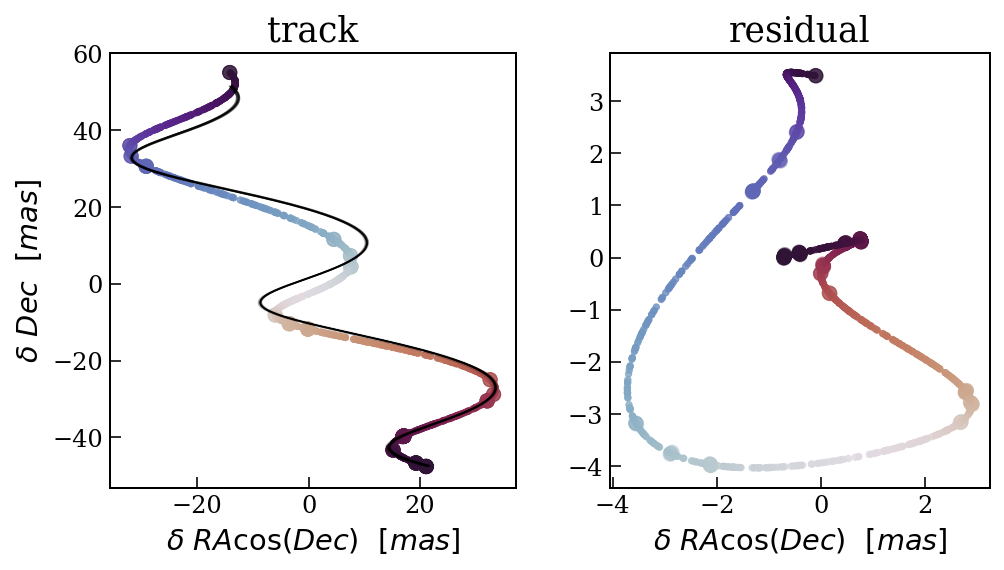

{'astrometric_matched_transits': 44, 'visibility_periods_used': 16, 'astrometric_n_obs_al': 396, 'astrometric_params_solved': 31, 'ra': 269.3719602389831, 'ra_error': 0.10219195392310065, 'dec': -28.079750121679975, 'dec_error': 0.09417728384209895, 'ra_dec_corr': -0.07416729717006902, 'parallax': 14.665898210984665, 'parallax_error': 0.12598836768565405, 'ra_parallax_corr': 0.2038770233866127, 'dec_parallax_corr': 0.5528576348388554, 'pmra': 23.089654365917056, 'pmra_error': 0.11511540329728982, 'ra_pmra_corr': -0.4112782488371969, 'dec_pmra_corr': 0.3675105939424824, 'parallax_pmra_corr': 0.2910819666921701, 'pmdec': -37.719562295167464, 'pmdec_error': 0.08645922019444673, 'ra_pmdec_corr': 0.13296208690439706, 'dec_pmdec_corr': -0.8815382000988106, 'parallax_pmdec_corr': -0.5191584698568807, 'pmra_pmdec_corr': -0.24180521289776724, 'astrometric_excess_noise': 0.6775788260255523, 'astrometric_chi2_al': 3012070.6062880745, 'astrometric_n_good_obs_al': 369, 'UWE': 90.96658313932738}
---

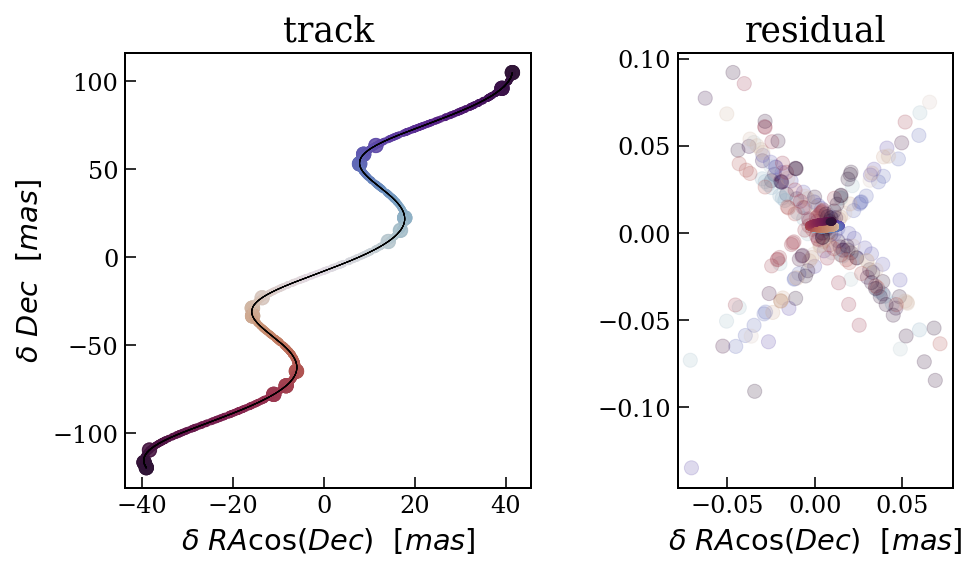

{'astrometric_matched_transits': 29, 'visibility_periods_used': 16, 'astrometric_n_obs_al': 261, 'astrometric_params_solved': 31, 'ra': 276.07704809813293, 'ra_error': 0.004848865589776229, 'dec': -32.96494814437156, 'dec_error': 0.0044738880900463684, 'ra_dec_corr': 0.24960330011249326, 'parallax': 10.154470760976327, 'parallax_error': 0.0054070605093362685, 'ra_parallax_corr': 0.06565831382740178, 'dec_parallax_corr': 0.34019153761099374, 'pmra': -23.708104021614048, 'pmra_error': 0.005929272386553841, 'ra_pmra_corr': -0.06360607513160955, 'dec_pmra_corr': -0.2654237825037953, 'parallax_pmra_corr': 0.024929438451237254, 'pmdec': -84.47638257180604, 'pmdec_error': 0.004963350700699595, 'ra_pmdec_corr': -0.2607257570496051, 'dec_pmdec_corr': -0.3884269768309632, 'parallax_pmdec_corr': -0.2525875420216574, 'pmra_pmdec_corr': 0.321085375346677, 'astrometric_excess_noise': 0.0, 'astrometric_chi2_al': 219.63020598057977, 'astrometric_n_good_obs_al': 261, 'UWE': 0.9262453735979682}
--------

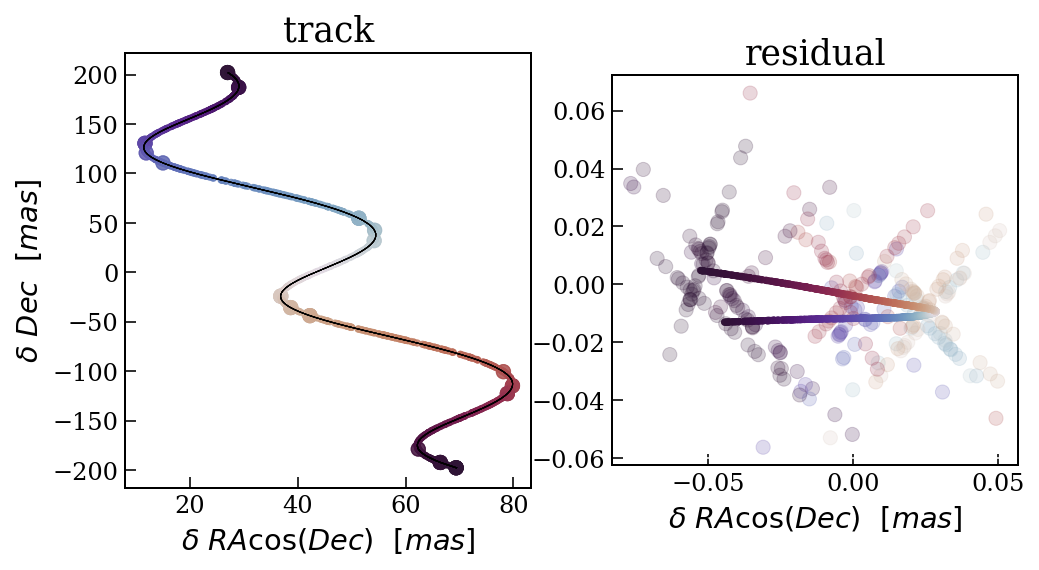

{'astrometric_matched_transits': 30, 'visibility_periods_used': 16, 'astrometric_n_obs_al': 270, 'astrometric_params_solved': 31, 'ra': 274.5130064868687, 'ra_error': 0.0026054850478076483, 'dec': -29.667224740106807, 'dec_error': 0.002325109783866349, 'ra_dec_corr': 0.19410669494808416, 'parallax': 14.421793166465221, 'parallax_error': 0.003146837831303902, 'ra_parallax_corr': 0.12435504755648834, 'dec_parallax_corr': 0.39922958144393805, 'pmra': 25.385262468165685, 'pmra_error': 0.0031556024104138474, 'ra_pmra_corr': -0.0630610976090855, 'dec_pmra_corr': -0.17416516108161698, 'parallax_pmra_corr': 0.17218116495197147, 'pmdec': -150.72620279067576, 'pmdec_error': 0.002490507152569463, 'ra_pmdec_corr': -0.2422582587562482, 'dec_pmdec_corr': -0.4661712043950872, 'parallax_pmdec_corr': -0.353445664351308, 'pmra_pmdec_corr': 0.21348841550763079, 'astrometric_excess_noise': 0.012681495940252968, 'astrometric_chi2_al': 399.5479095421131, 'astrometric_n_good_obs_al': 270, 'UWE': 1.2278957449

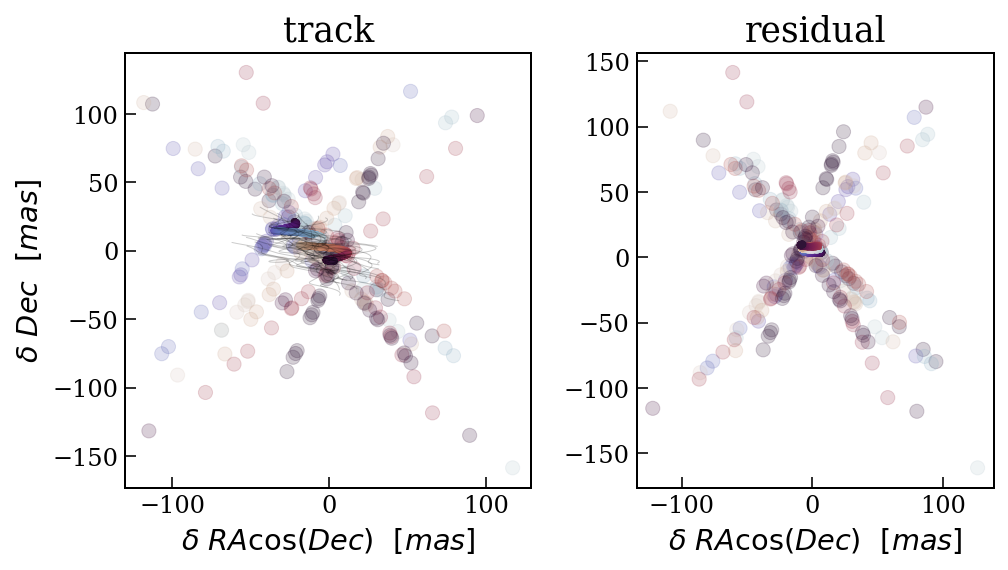

{'astrometric_matched_transits': 29, 'visibility_periods_used': 15, 'astrometric_n_obs_al': 261, 'astrometric_params_solved': 31, 'ra': 274.87003655257, 'ra_error': 6.058845422862334, 'dec': -29.34217727525587, 'dec_error': 5.586673056151942, 'ra_dec_corr': 0.1356975068415292, 'parallax': 4.076791250465941, 'parallax_error': 7.115157715546709, 'ra_parallax_corr': 0.042611509279522404, 'dec_parallax_corr': 0.4279024359736798, 'pmra': 17.647756878613432, 'pmra_error': 7.699216655373802, 'ra_pmra_corr': -0.14266918040297008, 'dec_pmra_corr': -0.12661538624972238, 'parallax_pmra_corr': 0.06091602855486101, 'pmdec': -13.195687765345369, 'pmdec_error': 6.014137947755908, 'ra_pmdec_corr': -0.1599794505708789, 'dec_pmdec_corr': -0.46597703930811135, 'parallax_pmdec_corr': -0.28249770742690294, 'pmra_pmdec_corr': 0.1230246732953463, 'astrometric_excess_noise': 0.0, 'astrometric_chi2_al': 273.4032201562612, 'astrometric_n_good_obs_al': 261, 'UWE': 1.0334318210387154}
----------------------------

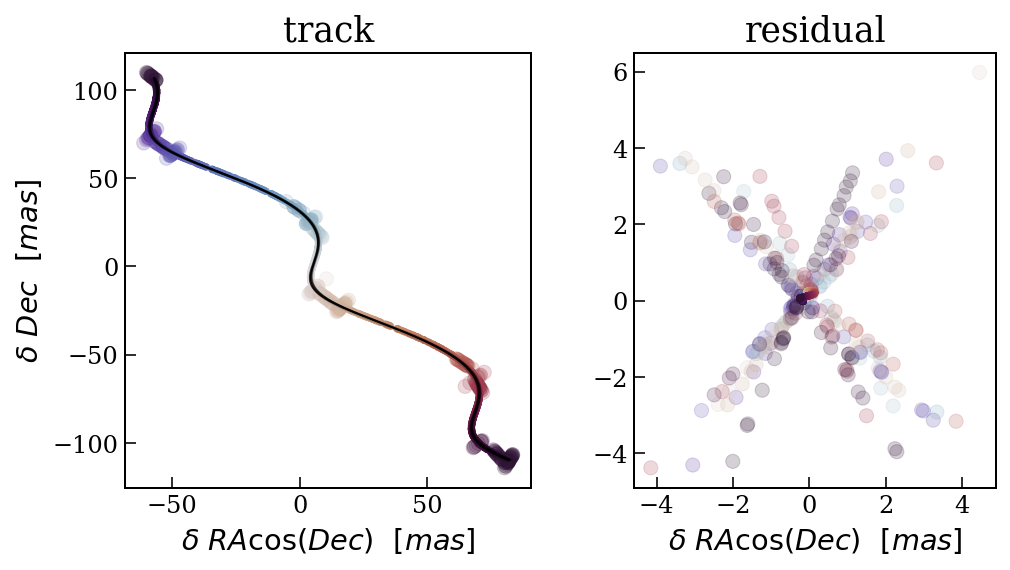

{'astrometric_matched_transits': 29, 'visibility_periods_used': 15, 'astrometric_n_obs_al': 261, 'astrometric_params_solved': 31, 'ra': 275.00792097584105, 'ra_error': 0.2413141151907213, 'dec': -33.03736154097007, 'dec_error': 0.20350917882755337, 'ra_dec_corr': 0.05165193540407799, 'parallax': 12.973315813253226, 'parallax_error': 0.2680701661475593, 'ra_parallax_corr': 0.15235676072705726, 'dec_parallax_corr': 0.313042736193256, 'pmra': 63.245038034909236, 'pmra_error': 0.30812704109957284, 'ra_pmra_corr': -0.05322008712001095, 'dec_pmra_corr': -0.06563810332648184, 'parallax_pmra_corr': 0.028658763297136163, 'pmdec': -85.28966529002287, 'pmdec_error': 0.22161641635224694, 'ra_pmdec_corr': -0.07594000467297451, 'dec_pmdec_corr': -0.3291118941631883, 'parallax_pmdec_corr': -0.14696852671619307, 'pmra_pmdec_corr': 0.067103902072651, 'astrometric_excess_noise': 0.0, 'astrometric_chi2_al': 247.30088270876647, 'astrometric_n_good_obs_al': 261, 'UWE': 0.9828626928931218}
-----------------

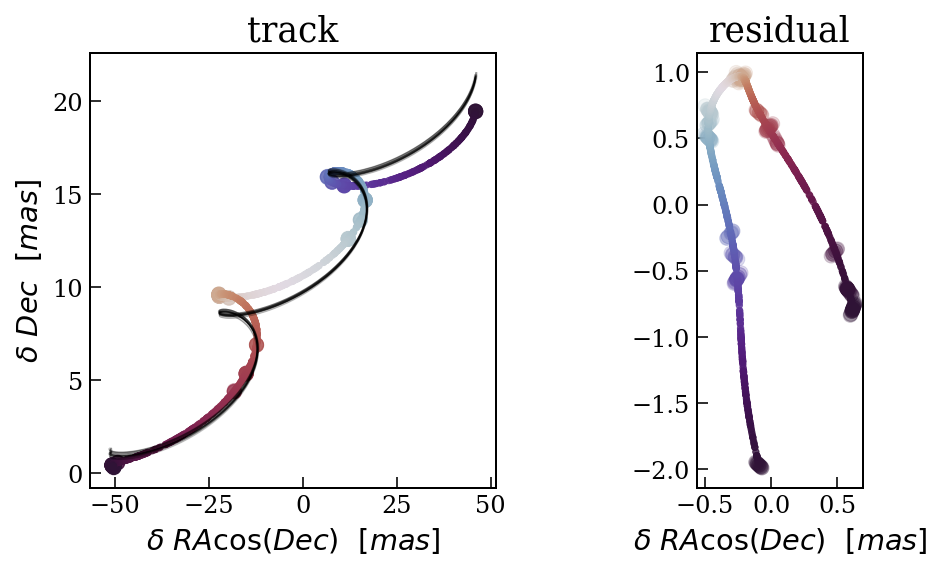

{'astrometric_matched_transits': 27, 'visibility_periods_used': 15, 'astrometric_n_obs_al': 243, 'astrometric_params_solved': 31, 'ra': 275.9092671144918, 'ra_error': 0.07544400337114157, 'dec': -30.306532040533273, 'dec_error': 0.06720803443421786, 'ra_dec_corr': 0.17320757994630107, 'parallax': 11.412697236793775, 'parallax_error': 0.08879468920425064, 'ra_parallax_corr': 0.10545721579707326, 'dec_parallax_corr': 0.3458752719997454, 'pmra': -29.1080038668415, 'pmra_error': 0.09169032596810221, 'ra_pmra_corr': -0.13564635024803667, 'dec_pmra_corr': -0.10658686784332926, 'parallax_pmra_corr': 0.18421131623798156, 'pmdec': -7.543733162383248, 'pmdec_error': 0.07331644093447054, 'ra_pmdec_corr': -0.194003672822922, 'dec_pmdec_corr': -0.4654415690646112, 'parallax_pmdec_corr': -0.33716777277931465, 'pmra_pmdec_corr': 0.09424949226083222, 'astrometric_excess_noise': 0.7025338403325725, 'astrometric_chi2_al': 239461.41463965538, 'astrometric_n_good_obs_al': 243, 'UWE': 31.719716228957832}
-

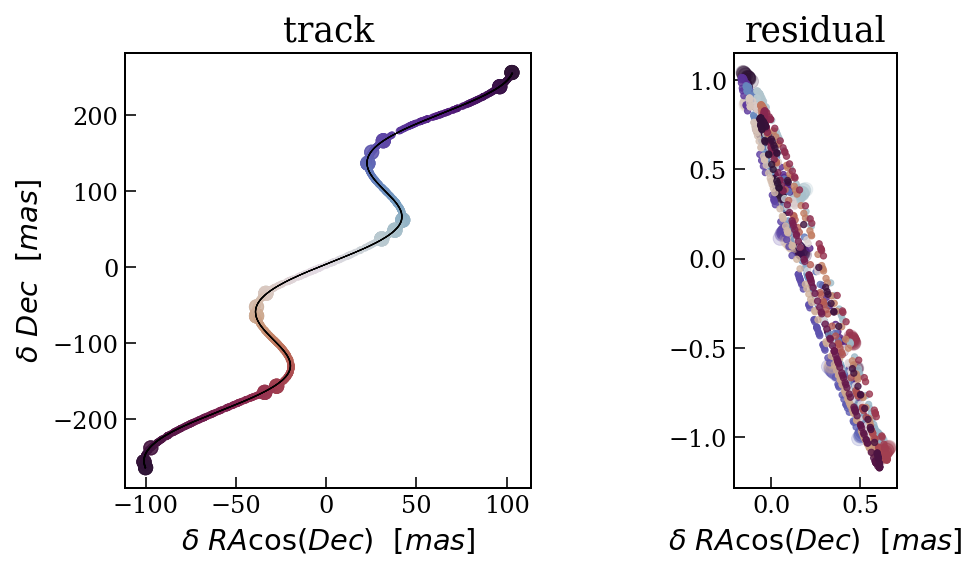

{'astrometric_matched_transits': 29, 'visibility_periods_used': 15, 'astrometric_n_obs_al': 261, 'astrometric_params_solved': 31, 'ra': 272.383276133627, 'ra_error': 0.059663710714601935, 'dec': -20.439131442354203, 'dec_error': 0.05064151738665547, 'ra_dec_corr': 0.024090375779844138, 'parallax': 22.927070002245742, 'parallax_error': 0.07405742066247835, 'ra_parallax_corr': 0.058733564515857095, 'dec_parallax_corr': 0.40591280885141734, 'pmra': -61.77539504797585, 'pmra_error': 0.07572415002199885, 'ra_pmra_corr': 0.137045860867588, 'dec_pmra_corr': -0.10737974609241308, 'parallax_pmra_corr': 0.18838434429070122, 'pmdec': -195.7076235053877, 'pmdec_error': 0.05784945320487832, 'ra_pmdec_corr': -0.13767900978207054, 'dec_pmdec_corr': -0.29146517050273, 'parallax_pmdec_corr': -0.3419188196468699, 'pmra_pmdec_corr': 0.15912071323299537, 'astrometric_excess_noise': 0.5741875939119392, 'astrometric_chi2_al': 237579.6151604674, 'astrometric_n_good_obs_al': 261, 'UWE': 30.46383711420109}
---

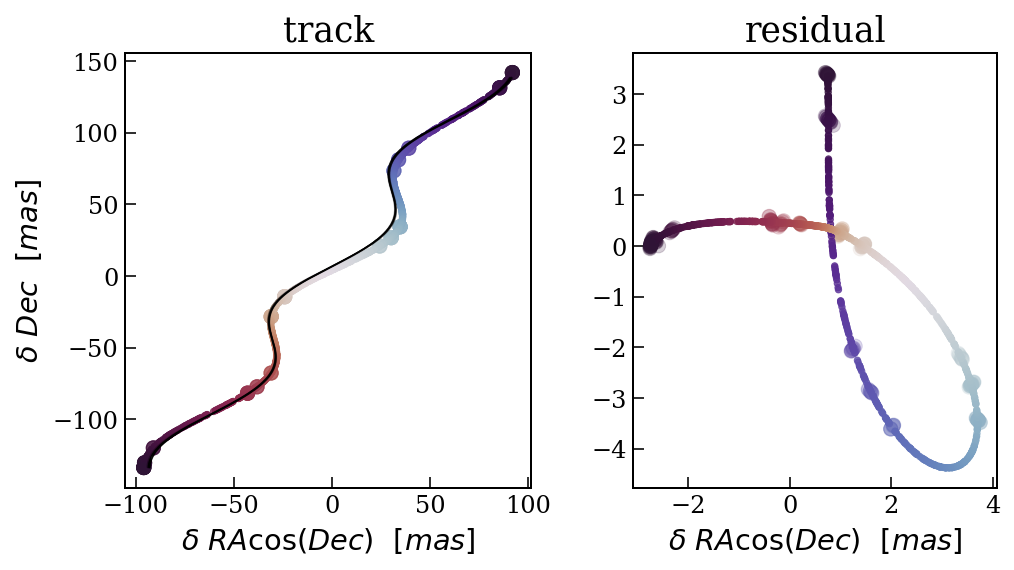

{'astrometric_matched_transits': 26, 'visibility_periods_used': 15, 'astrometric_n_obs_al': 234, 'astrometric_params_solved': 31, 'ra': 270.67835412875644, 'ra_error': 0.19134280834470146, 'dec': -24.28149737953494, 'dec_error': 0.1644324063645805, 'ra_dec_corr': 0.020005840903492767, 'parallax': 13.292858444381746, 'parallax_error': 0.23316705446858793, 'ra_parallax_corr': -0.03773620580588901, 'dec_parallax_corr': 0.4084317522567704, 'pmra': -61.09757866754322, 'pmra_error': 0.24175143251011602, 'ra_pmra_corr': 0.04185328331107767, 'dec_pmra_corr': -0.2113776708787962, 'parallax_pmra_corr': 0.2072736863462993, 'pmdec': -102.96352763071474, 'pmdec_error': 0.16550215509890093, 'ra_pmdec_corr': -0.1616145357813667, 'dec_pmdec_corr': -0.4345735765557474, 'parallax_pmdec_corr': -0.21530935194102077, 'pmra_pmdec_corr': 0.30591570582165195, 'astrometric_excess_noise': 1.6182260698678586, 'astrometric_chi2_al': 459761.4091144061, 'astrometric_n_good_obs_al': 234, 'UWE': 44.807273325406314}
-

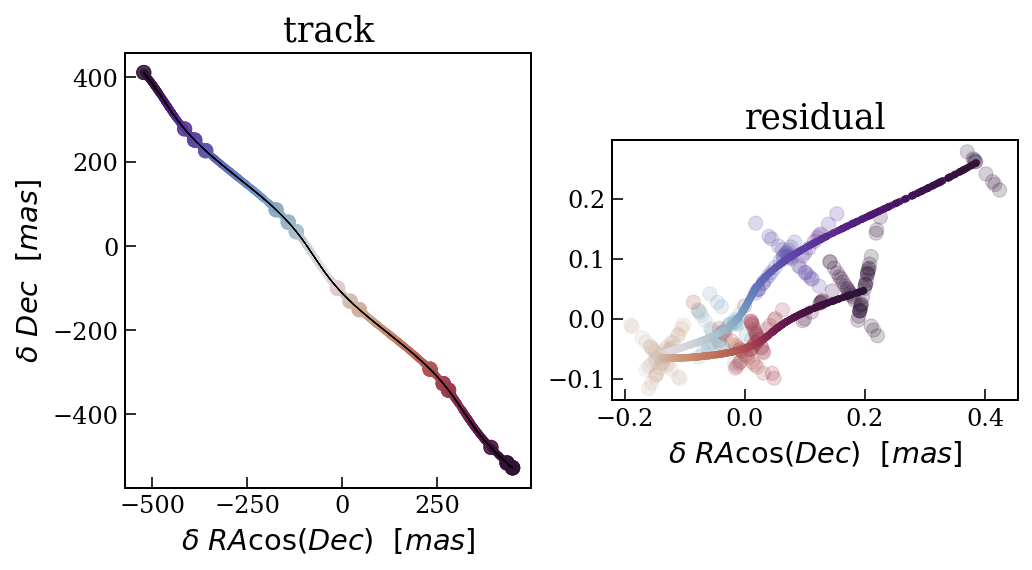

{'astrometric_matched_transits': 29, 'visibility_periods_used': 15, 'astrometric_n_obs_al': 261, 'astrometric_params_solved': 31, 'ra': 270.62797504904364, 'ra_error': 0.009218397174783793, 'dec': -23.70031333140076, 'dec_error': 0.007572427452167135, 'ra_dec_corr': 0.06285045650877305, 'parallax': 18.949688028113556, 'parallax_error': 0.009926727566107256, 'ra_parallax_corr': 0.12017133120640455, 'dec_parallax_corr': 0.22452074812360287, 'pmra': 392.5252121820918, 'pmra_error': 0.012790097713706622, 'ra_pmra_corr': -0.15117512758085164, 'dec_pmra_corr': -0.08256150878062414, 'parallax_pmra_corr': -0.05565266141150508, 'pmdec': -367.83197903383353, 'pmdec_error': 0.008721385631756826, 'ra_pmdec_corr': -0.06058444124817399, 'dec_pmdec_corr': -0.442419570494152, 'parallax_pmdec_corr': -0.10743809985390199, 'pmra_pmdec_corr': 0.10541705547476911, 'astrometric_excess_noise': 0.07849521095027313, 'astrometric_chi2_al': 1510.668930730823, 'astrometric_n_good_obs_al': 261, 'UWE': 2.4292077948

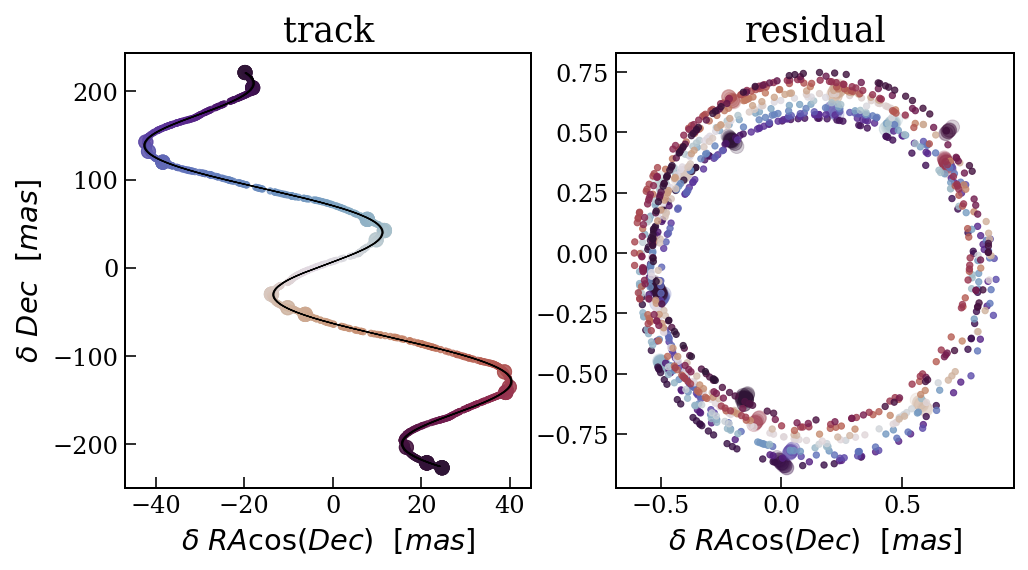

{'astrometric_matched_transits': 30, 'visibility_periods_used': 16, 'astrometric_n_obs_al': 270, 'astrometric_params_solved': 31, 'ra': 270.32151822305076, 'ra_error': 0.05416465786104885, 'dec': -24.023036549522555, 'dec_error': 0.0462715434720672, 'ra_dec_corr': 0.1477112150128068, 'parallax': 18.801025701572385, 'parallax_error': 0.06794079568580437, 'ra_parallax_corr': 0.0759709720833381, 'dec_parallax_corr': 0.40660775593041526, 'pmra': 29.119805311500997, 'pmra_error': 0.07063324258012735, 'ra_pmra_corr': 0.03426386254474779, 'dec_pmra_corr': -0.07338602168480832, 'parallax_pmra_corr': 0.2562549044674237, 'pmdec': -168.98223751096168, 'pmdec_error': 0.04947328456366488, 'ra_pmdec_corr': -0.1001765547535075, 'dec_pmdec_corr': -0.4500457282616854, 'parallax_pmdec_corr': -0.29615701061776933, 'pmra_pmdec_corr': 0.3008049896252526, 'astrometric_excess_noise': 0.5160939669080531, 'astrometric_chi2_al': 319460.2949828137, 'astrometric_n_good_obs_al': 270, 'UWE': 34.72046294485368}


In [25]:
for i in tqdm(range(16)):
    
    params=astromet.params()
    params.ra=uras[i]
    params.dec=udecs[i]
    
    c=Source(params.ra,params.dec,unit='deg')
    sl=dr3_sl(c, return_times=True, return_angles=True)
    ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
    sort=np.argsort(ts)
    ts=ts[sort]
    
    phis=np.squeeze(np.hstack(sl['angles']))[sort]
    
    params.parallax=upllxs[i]
    params.pmrac=upmras[i]
    params.pmdec=upmdecs[i]
    
    params.period=uperiods[i]
    params.a=uas[i]
    params.e=ues[i]
    
    params.l=uls[i]
    params.q=uqs[i]
    
    params.vtheta=uvthetas[i]
    params.vphi=uvphis[i]
    params.vomega=uvomegas[i]
    
    params.tperi=utperis[i]
    
    alError=astromet.sigma_ast(umags[i])
    
    trueRacs,trueDecs=astromet.track(ts,params)
    
    t_obs,x_obs,phi_obs,rac_obs,dec_obs=astromet.mock_obs(ts,phis,trueRacs,trueDecs,err=alError)
    
    fitresults=astromet.fit(t_obs,x_obs,phi_obs,alError,params.ra,params.dec)
    results=astromet.gaia_results(fitresults)
    
    #print('mag: ',umags[i])
    print('---------------------------------------')
    print('ra, dec, pllx, pmrac, pmdec ',params.ra,params.dec,params.parallax,params.pmrac,params.pmdec)
    print('period ',params.period)
    print('a ',params.a)
    print('e ',params.e)
    print('Delta ',astromet.Delta(params))
    print('UWE ',fitresults["UWE"])
    #print(results)
    
     #optionally plot tracks
    plotts=np.sort(ts[0]+(ts[-1]-ts[0])*np.random.rand(1000))
    plotRacs,plotDecs=astromet.track(plotts,params)
    
    fig=plt.figure(figsize=(8,4))
    grid=mpl.gridspec.GridSpec(1,2)
    ax=plt.subplot(grid[0,0])
    ax.set_title('track')
    fitparams=astromet.params()
    for i in range(32):
        fitparams.ra=params.ra
        fitparams.dec=params.dec
        fitparams.drac=fitresults['drac']+np.random.randn()*fitresults['drac_error']
        fitparams.ddec=fitresults['ddec']+np.random.randn()*fitresults['ddec_error']
        fitparams.pmrac=fitresults['pmrac']+np.random.randn()*fitresults['pmrac_error']
        fitparams.pmdec=fitresults['pmdec']+np.random.randn()*fitresults['pmdec_error']
        fitparams.parallax=fitresults['parallax']+np.random.randn()*fitresults['parallax_error']
        
        fitRacs,fitDecs=astromet.track(plotts,fitparams)
        ax.plot(fitRacs,fitDecs,c='k',alpha=0.2,lw=0.5)
    ax.scatter(rac_obs,dec_obs,c=t_obs,alpha=0.2,s=50,cmap='twilight_shifted')
    ax.scatter(plotRacs,plotDecs,c=plotts,s=10,alpha=0.8,cmap='twilight_shifted')
    ax.set_xlabel(r'$\delta \ RA \cos(Dec) \ \ [mas]$')
    ax.set_ylabel(r'$\delta \ Dec \ \ [mas]$')
    
    ax=plt.subplot(grid[0,1])
    ax.set_title('residual')
    bestparams=astromet.params()
    bestparams.ra=params.ra
    bestparams.dec=params.dec
    bestparams.drac=fitresults['drac']
    bestparams.ddec=fitresults['ddec']
    bestparams.pmrac=fitresults['pmrac']
    bestparams.pmdec=fitresults['pmdec']
    bestparams.parallax=fitresults['parallax']
    bestRacs,bestDecs=astromet.track(plotts,bestparams)
    bestRac_obs,bestDec_obs=astromet.track(t_obs,bestparams)
    
    ax.scatter(rac_obs-bestRac_obs,dec_obs-bestDec_obs,c=t_obs,
               alpha=0.2,s=50,cmap='twilight_shifted')
    ax.scatter(plotRacs-bestRacs,plotDecs-bestDecs,c=plotts,
               s=10,alpha=0.8,cmap='twilight_shifted')
    ax.set_xlabel(r'$\delta \ RA \cos(Dec) \ \ [mas]$')
    ax.set_aspect('equal')
    plt.show()
    print(results)